In [1]:
import nltk
import warnings

warnings.filterwarnings('ignore')
nltk.download("all", quiet=True)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


True

In [2]:
import random, os
import numpy as np
import torch

def seed_everything(seed: int):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
seed_everything(42)

In [3]:
import datasets
import pandas as pd
from ast import literal_eval
datasets.set_caching_enabled(False)

data_dir = '../input/vispamdataset-v2/preprocessed/'

def load_data(data_dir):
    train_df = pd.read_csv(data_dir + 'train.csv', converters={'categories': literal_eval})
    dev_df = pd.read_csv(data_dir + 'dev.csv', converters={'categories': literal_eval})
    test_df = pd.read_csv(data_dir + 'test.csv', converters={'categories': literal_eval})
    
    train_dataset = datasets.Dataset.from_dict(train_df)
    dev_dataset = datasets.Dataset.from_dict(dev_df)
    test_dataset = datasets.Dataset.from_dict(test_df)
    dataset_dict = datasets.DatasetDict({'train': train_dataset, 'dev': dev_dataset, 'test': test_dataset})
    
    return train_df, dev_df, test_df, dataset_dict

train_df, dev_df, test_df, vispam_datasets = load_data(data_dir)

In [4]:
import numpy as np
from nltk.tokenize import word_tokenize

def tokenizing(texts):
    max_len = 0
    tokenized_texts = []
    word2idx = {}
    
    word2idx['<pad>'] = 0
    word2idx['<unk>'] = 1
    
    idx = 2
    for sent in texts:
        tokenized_sent = word_tokenize(sent)
        tokenized_texts.append(tokenized_sent)
        
        for token in tokenized_sent:
            if token not in word2idx:
                word2idx[token] = idx
                idx += 1
                
        max_len = max(max_len, len(tokenized_sent))
        
    return tokenized_texts, word2idx, max_len


def encoding(tokenized_texts, word2idx, max_len=100):
    input_ids = []
    for tokenized_sent in tokenized_texts:
        if len(tokenized_sent) > max_len:
            tokenized_sent = tokenized_sent[:max_len]
            
        tokenized_sent += ['<pad>'] * (max_len - len(tokenized_sent))
        
        input_id = [word2idx.get(token, word2idx['<unk>']) for token in tokenized_sent]
        input_ids.append(input_id)
    
    return np.array(input_ids)

In [5]:
train_tokenized, word2idx, max_len = tokenizing(vispam_datasets['train']['clean_comment'])
print('Number of words:', len(word2idx))
print('Max length of sentence:', max_len)

Number of words: 15359
Max length of sentence: 215


In [6]:
def encode_mapping(examples):
    tokenized_texts = [word_tokenize(sent) for sent in examples['clean_comment']]
    input_ids = encoding(tokenized_texts, word2idx, max_len=100)
    
    return {'input_ids': input_ids}


encoded_datasets = vispam_datasets.map(encode_mapping, batched=True)
encoded_datasets = encoded_datasets.remove_columns(vispam_datasets['train'].column_names[:-2])
encoded_datasets.set_format("torch")

  0%|          | 0/15 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/4 [00:00<?, ?ba/s]

In [7]:
import torch
import numpy as np
from tqdm import tqdm_notebook

def load_pretrained_vectors(word2idx, file_name):
    fin = open(file_name, 'r', encoding='utf-8', newline='\n', errors='ignore')
    n, d = map(int, fin.readline().split())
    
    embeddings = np.random.uniform(-0.25, 0.25, (len(word2idx), d))
    embeddings[word2idx['<pad>']] = np.zeros((d,))
    
    count = 0
    for line in tqdm_notebook(fin):
        tokens = line.rstrip().split(' ')
        word = tokens[0]
        if word in word2idx:
            count += 1
            embeddings[word2idx[word]] = np.array(tokens[1:], dtype=np.float32)
            
    print(f"There are {count} / {len(word2idx)} pretrained vectors found.")
    
    return embeddings


file_name = "../input/fasttext-pretrained-embeddings/cc.vi.300.vec"
embeddings = load_pretrained_vectors(word2idx, file_name)
embeddings = torch.tensor(embeddings)

0it [00:00, ?it/s]

There are 8584 / 15359 pretrained vectors found.


In [8]:
import os
import gc
import json
import numpy as np
from scipy import interpolate
from pathlib import Path
import torch
from torch import nn
from tqdm.notebook import tqdm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


def evaluate(true_labels, predicts):
    test_accuracy = accuracy_score(true_labels, predicts)
    test_precision = precision_score(true_labels, predicts, average='macro')
    test_recall = recall_score(true_labels, predicts, average='macro')
    test_f1 = f1_score(true_labels, predicts, average='macro')
    test_cm = confusion_matrix(true_labels, predicts)

    print("Accuracy: {:.4f}".format(test_accuracy))
    print("Precision: {:.4f}".format(test_precision))
    print("Recall: {:.4f}".format(test_recall))
    print("F1-score: {:.4f}".format(test_f1))
    print("Confusion matrix:\n", test_cm)
    print(classification_report(true_labels, predicts, digits=4))
    
    return test_cm


def plotting_confusion_matrix(confusion_matrix, model_name, task):
    Path(model_name).mkdir(parents=True, exist_ok=True)
    
    if task == 1:
        labels = ['no-spam', 'spam']
        font_size = 30
    else:
        labels = ['no-spam', 'spam-1', 'spam-2', 'spam-3']
        font_size = 22
        
    plt.figure(dpi=100)
    df_cm = pd.DataFrame(confusion_matrix, index=labels, columns=labels)
    ax = sns.heatmap(df_cm, annot=True, cmap="Greys", fmt="g", cbar=True, annot_kws={"size": font_size})
    
    file_name = os.path.join(model_name, f"{model_name}_confusion_matrix_({task}).pdf")
    plt.savefig(file_name, dpi=300, bbox_inches='tight')
    plt.show()

In [9]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

# TextCNN

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class TextCNN(nn.Module):
    def __init__(self, task, kernel_sizes=[2, 3, 5], num_filters=32, drop=0.5, spatial_dropout=False, mode='static'):
        super(TextCNN, self).__init__()
        
        self.task = task
        self.num_classes = 2 if task == 1 else 4
        self.vocab_size, self.embedding_dim = embeddings.shape
        self.kernel_sizes = kernel_sizes
        self.num_filters = num_filters
        self.drop = drop
        self.spatial_dropout = spatial_dropout
        self.mode = mode
        
        self.embedding = nn.Embedding(self.vocab_size, self.embedding_dim, padding_idx=0)
        self.load_embeddings()
        
        if spatial_dropout:
            self.spatial_dropout1d = nn.Dropout2d(drop)
            
        self.conv = nn.ModuleList([nn.Conv1d(in_channels=self.embedding_dim, out_channels=num_filters, kernel_size=k, stride=1) for k in kernel_sizes])
        self.dropout = nn.Dropout(drop)
        self.fc = nn.Linear(len(kernel_sizes) * num_filters, self.num_classes)

    def forward(self, input_ids):
        batch_size, sequence_length = input_ids.shape
        h_embedding = self.embedding(input_ids).float()
        
        if self.spatial_dropout:
            h_embedding = h_embedding.permute(0, 2, 1)
            h_embedding = self.spatial_dropout1d(h_embedding)
            h_embedding = h_embedding.permute(0, 2, 1)
        
        x = h_embedding.permute(0, 2, 1)
        x = [F.relu(conv(x)) for conv in self.conv]
        x = [F.max_pool1d(c, kernel_size=c.shape[2]).squeeze(dim=2) for c in x]
        x = torch.cat(x, dim=1)
        x = self.dropout(x)
        x = self.fc(x)
        
        return x

    def load_embeddings(self):
        if 'static' in self.mode:
            self.embedding.weight.data.copy_(embeddings)
            if 'non' not in self.mode:
                self.embedding.weight.data.requires_grad = False
                print('Loaded pretrained embeddings, weights are not trainable.')
            else:
                self.embedding.weight.data.requires_grad = True
                print('Loaded pretrained embeddings, weights are trainable.')
        elif self.mode == 'rand':
            print('Randomly initialized embeddings are used.')
        else:
            raise ValueError('Unexpected value of mode. Please choose from static, non-static, rand.')
            

class BiLSTM(nn.Module):
    
    def __init__(self, task, hidden_size=64, drop=0.5, spatial_dropout=True, mode='static'):
        super(BiLSTM, self).__init__()
        
        self.task = task
        self.num_classes = 2 if task == 1 else 4
        self.vocab_size, self.embedding_dim = embeddings.shape
        self.hidden_size = hidden_size
        self.drop = drop
        self.spatial_dropout = spatial_dropout
        self.mode = mode
        
        if spatial_dropout:
            self.spatial_dropout1d = nn.Dropout2d(drop)
        
        self.embedding = nn.Embedding(self.vocab_size, self.embedding_dim, padding_idx=0)
        self.load_embeddings()
        self.lstm = nn.LSTM(self.embedding_dim, hidden_size, bidirectional=True, batch_first=True)
        self.linear = nn.Linear(hidden_size*4 , 64)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(drop)
        self.fc = nn.Linear(64, self.num_classes)
        
    def forward(self, input_ids):
        batch_size, sequence_length = input_ids.shape
        h_embedding = self.embedding(input_ids).float()
        
        if self.spatial_dropout:
            h_embedding = h_embedding.permute(0, 2, 1)
            h_embedding = self.spatial_dropout1d(h_embedding)
            h_embedding = h_embedding.permute(0, 2, 1)
        
        h_lstm, _ = self.lstm(h_embedding)
        avg_pool = torch.mean(h_lstm, 1)
        max_pool, _ = torch.max(h_lstm, 1)
        conc = torch.cat((avg_pool, max_pool), 1)
        conc = self.relu(self.linear(conc))
        conc = self.dropout(conc)
        out = self.fc(conc)
        
        return out
    
    def load_embeddings(self):
        if 'static' in self.mode:
            self.embedding.weight.data.copy_(embeddings)
            if 'non' not in self.mode:
                self.embedding.weight.data.requires_grad = False
                print('Loaded pretrained embeddings, weights are not trainable.')
            else:
                self.embedding.weight.data.requires_grad = True
                print('Loaded pretrained embeddings, weights are trainable.')
        elif self.mode == 'rand':
            print('Randomly initialized embeddings are used.')
        else:
            raise ValueError('Unexpected value of mode. Please choose from static, non-static, rand.')
            

class BiGRU(nn.Module):
    
    def __init__(self, task, hidden_size=64, drop=0.5, spatial_dropout=True, mode='static'):
        super(BiGRU, self).__init__()
        
        self.task = task
        self.num_classes = 2 if task == 1 else 4
        self.vocab_size, self.embedding_dim = embeddings.shape
        self.hidden_size = hidden_size
        self.drop = drop
        self.spatial_dropout = spatial_dropout
        self.mode = mode
        
        self.embedding = nn.Embedding(self.vocab_size, self.embedding_dim, padding_idx=0)
        
        if spatial_dropout:
            self.spatial_dropout1d = nn.Dropout2d(drop)
        
        self.load_embeddings()
        self.gru = nn.GRU(self.embedding_dim, hidden_size, bidirectional=True, batch_first=True)
        self.linear = nn.Linear(hidden_size*4, 64)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(drop)
        self.fc = nn.Linear(64, self.num_classes)
        
    def forward(self, input_ids):
        batch_size, sequence_length = input_ids.shape
        h_embedding = self.embedding(input_ids).float()
        
        if self.spatial_dropout:
            h_embedding = h_embedding.permute(0, 2, 1)
            h_embedding = self.spatial_dropout1d(h_embedding)
            h_embedding = h_embedding.permute(0, 2, 1)
            
        h_gru, _ = self.gru(h_embedding)
        avg_pool = torch.mean(h_gru, 1)
        max_pool, _ = torch.max(h_gru, 1)
        conc = torch.cat((avg_pool, max_pool), 1)
        conc = self.relu(self.linear(conc))
        conc = self.dropout(conc)
        out = self.fc(conc)
        
        return out
    
    def load_embeddings(self):
        if 'static' in self.mode:
            self.embedding.weight.data.copy_(embeddings)
            if 'non' not in self.mode:
                self.embedding.weight.data.requires_grad = False
                print('Loaded pretrained embeddings, weights are not trainable.')
            else:
                self.embedding.weight.data.requires_grad = True
                print('Loaded pretrained embeddings, weights are trainable.')
        elif self.mode == 'rand':
            print('Randomly initialized embeddings are used.')
        else:
            raise ValueError('Unexpected value of mode. Please choose from static, non-static, rand.')
            

def test(model, dataloader, task):
    model.eval()
    
    predicts = []
    predict_probs = []
    true_labels = []
    
    label_column = 'label' if task == 1 else 'spam_label'
    
    for data in tqdm(dataloader):
        input_ids = data['input_ids'].to(device)
        labels = data[label_column].to(device)
        
        with torch.no_grad():
            outputs = model(input_ids)
         
        pred = torch.max(outputs, dim=1)[1]
        predicts.extend(pred.cpu().data.numpy())
        predict_probs.extend(outputs.cpu().data.numpy())
        true_labels.extend(labels.cpu().data.numpy())
        
    return true_labels, predicts

In [11]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(encoded_datasets['train'], shuffle=True, batch_size=256)
val_dataloader = DataLoader(encoded_datasets['dev'], batch_size=256)
test_dataloader = DataLoader(encoded_datasets['test'], batch_size=256)

Loaded pretrained embeddings, weights are not trainable.


  0%|          | 0/16 [00:00<?, ?it/s]

Accuracy: 0.8226
Precision: 0.7727
Recall: 0.7709
F1-score: 0.7718
Confusion matrix:
 [[2565  346]
 [ 357  695]]
              precision    recall  f1-score   support

           0     0.8778    0.8811    0.8795      2911
           1     0.6676    0.6606    0.6641      1052

    accuracy                         0.8226      3963
   macro avg     0.7727    0.7709    0.7718      3963
weighted avg     0.8220    0.8226    0.8223      3963



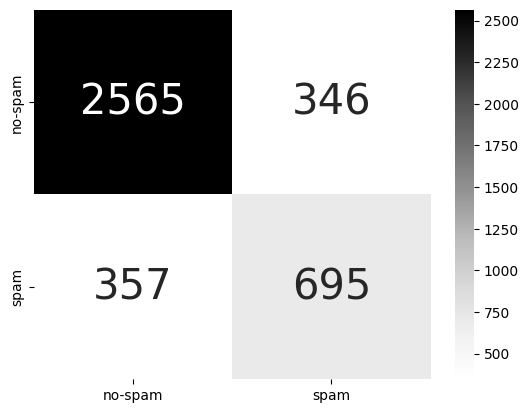

In [12]:
import os
import torch

model_name = "TextCNN"
model_path = f"../input/vispamreviews-models/{model_name}/{model_name}_(1).pth"
model = TextCNN(task=1).to(device)
model.load_state_dict(torch.load(model_path))
true_labels, predicts = test(model, test_dataloader, task=1)
test_cm = evaluate(true_labels, predicts)
plotting_confusion_matrix(test_cm, model_name, task=1)

In [13]:
import os
import pandas as pd

predict_df = pd.DataFrame({'comment': vispam_datasets['test']['comment'],
                           'category': vispam_datasets['test']['category'],
                           'description': vispam_datasets['test']['description'],
                           'label': true_labels, 'predict': predicts})
predict_df.to_csv(os.path.join(model_name, f'{model_name}_test_prediction_(1).csv'), index=False)
wrong_df = predict_df[predict_df.label != predict_df.predict]
sorted_df = wrong_df.sort_values(['label', 'predict'], ascending=[False, False])
sorted_df

comment  \
8     Kakaa ba n·∫±m b√™n tr√°i th√¨ e b√© nh√©t qua b√™n tr...   
25    H√†ng ƒë·∫πp . giao r·∫•t ok , ·ªßng h·ªô ·∫° \r\nH√†ng ƒë·∫πp...   
34    Giao h√†ng nhanh. H√¨nh ·∫£nh vs video mang t√≠nh c...   
38    Mua bnh c√°i t√∫i ƒë·ª±ng b√†i c≈©ng k bao h l√† ƒë·ªß ·∫•y...   
44    Kh√¥ng ch·ª•p ·∫£nh ƒë∆∞·ª£c s·∫£n ph·∫©m n√™n m√¨nh l·∫•y t·∫°m ...   
...                                                 ...   
3913  Si√™u tooooo\r\nGiao h√†ng si√™u nhanh\r\nH√†ng s·ª≠...   
3924  D√πng tr√™n MacOS n√©t l·∫Øm anh em nh√©, m·ªçi ng∆∞·ªùi ...   
3937  Giao h√†ng nhanh, ƒë√≥ng g√≥i c·∫©n th·∫≠n. H√†ng ch·∫•t ...   
3945                                 H√†ng t·ªõi h l√† ngon   
3951  M√¨nh m·ªõi v·ª´a nh·∫≠n h√†ng, ƒë·ªëng g√≥i sp ƒë·∫πp, chƒÉcs...   

                   category  \
8                Th·ªùi Trang   
25                     S√°ch   
34       Nh√† C·ª≠a - ƒê·ªùi S·ªëng   
38       Nh√† C·ª≠a - ƒê·ªùi S·ªëng   
44                  M√°y ·∫¢nh   
...                     ...   
3913                ƒêi·ªán T·ª≠   
3924  ƒêi·ªán Thoai - M√°y T√≠nh   
3937             Th·ªùi Trang   
3945  ƒêi·ªán Thoai - M√°y T√≠nh   
3951                ƒêi·ªán T·ª≠   

                                            description  label  predict  
8     Qu·∫ßn l√≥t nam thun l·∫°nh nh·∫≠t b·∫£n, qu·∫ßn s·ªãp ƒë√∫c ...      1        0  
25    Th·ªùi gian giao h√†ng d·ª± ki·∫øn cho s·∫£n ph·∫©m n√†y l...      1        0  
34    5 l∆∞u √Ω tr∆∞·ªõc khi ƒë·∫∑t h√†ng: 1 - Mi·ªÖn ph√≠ v·∫≠n c...      1        0  
38    T√∫i Nhung ƒê∆∞ng Tarot Ti·ªÅn Cao C·∫•p T√∫i v·∫£i nhun...      1        0  
44    ƒê·∫∑c t√≠nh ∆∞u Vi·ªát c·ªßa Camera Yoosee Ti·∫øng Vi·ªát ...      1        0  
...                                                 ...    ...      ...  
3913  GIAO HAÃÄNG VAÃÄ LAÃÜÃÅP ƒêAÃ£ÃÜT CUÃÄNG LUÃÅCGiaÃÅ saÃân...      0        1  
3924  Xem theÃÇm ƒëeÃÇÃâ baÃ£n coÃÅ theÃÇÃâ laÃÄm nhieÃÇÃÄu hoÃõ...      0        1  
3937  GI·ªöI THI·ªÜU S·∫¢N PH·∫®M : T·∫•t nam n·ªØ c·ªï cao tr·∫Øng ...      0        1  
3945  MaÃÄn hiÃÄnh Liquid Retina iPad Air moÃõÃÅi soÃõÃâ h...      0        1  
3951  ThieÃÇÃÅt keÃÇÃÅ goÃ£n ƒëeÃ£p, voÃâ maÃÅy chaÃÇÃÅt lieÃ£ÃÇu...      0        1  

[703 rows x 5 columns]

Loaded pretrained embeddings, weights are not trainable.


  0%|          | 0/16 [00:00<?, ?it/s]

Accuracy: 0.7858
Precision: 0.5841
Recall: 0.6585
F1-score: 0.6064
Confusion matrix:
 [[2458   46  278  129]
 [  17   29    4    4]
 [ 100    1  192   16]
 [ 203   11   40  435]]
              precision    recall  f1-score   support

           0     0.8848    0.8444    0.8641      2911
           1     0.3333    0.5370    0.4113        54
           2     0.3735    0.6214    0.4666       309
           3     0.7449    0.6313    0.6834       689

    accuracy                         0.7858      3963
   macro avg     0.5841    0.6585    0.6064      3963
weighted avg     0.8131    0.7858    0.7955      3963



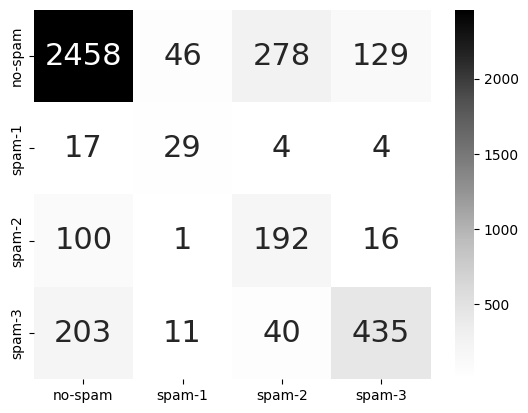

In [14]:
import os
import torch

model_name = "TextCNN"
model_path = f"../input/vispamreviews-models/{model_name}/{model_name}_(2).pth"
model = TextCNN(task=2).to(device)
model.load_state_dict(torch.load(model_path))
true_labels, predicts = test(model, test_dataloader, task=2)
test_cm = evaluate(true_labels, predicts)
plotting_confusion_matrix(test_cm, model_name, task=2)

In [15]:
import os
import pandas as pd

predict_df = pd.DataFrame({'comment': vispam_datasets['test']['comment'],
                           'category': vispam_datasets['test']['category'],
                           'description': vispam_datasets['test']['description'],
                           'spam_label': true_labels, 'predict': predicts})
predict_df.to_csv(os.path.join(model_name, f'{model_name}_test_prediction_(2).csv'), index=False)
wrong_df = predict_df[predict_df.spam_label != predict_df.predict]
sorted_df = wrong_df.sort_values(['spam_label', 'predict'], ascending=[False, False])
sorted_df

comment  \
59    H√†ng ·∫° g·ªüi b√†i v√†o v√†o ƒë√¢y ·∫° g·ª≠i g·ª≠i v√†o t√∫i n...   
90                   N√≥i chung l√† h√†i l√≤ng nhe qu√Ω d·ªã üëç   
285   Giao ch·∫≠m nhg nhanh nh∆∞ c∆°n gi√≥, ship uy t√≠n n...   
536   Giao h√†ng h∆°i l√¢u, ƒë√≥ng g√≥i ƒë∆∞·ª£c, n√≥i chung c≈©...   
568   T·ªët , h√†ng nh∆∞ h√¨nh, ship nhanh ·∫° hsjddjdkaksh...   
...                                                 ...   
3351                              Hai long voi san pham   
3821  Shop ph·ª•c v·ª• r·∫•t t·ªët. R·∫•t ƒë√°ng ti·ªÅn. Th·ªùi gian...   
3829  Giao h√†ng nhanh balo ƒë·ªânh lu√¥n v·ªõi gi√° th·∫ø n√†y...   
3867  C√°p s√†ng faceid uy t√≠n giao h√†ng nhanh ch√≥ng ,...   
3879  Ch·∫•t l∆∞·ª£ng s·∫£n ph·∫©m tuy·ªát v·ªùi, giao h√†ng nhanh...   

                   category  \
59               Th·ªùi Trang   
90                     Kh√°c   
285                    Kh√°c   
536      Nh√† C·ª≠a - ƒê·ªùi S·ªëng   
568                 S·∫Øc ƒê·∫πp   
...                     ...   
3351                ƒê·ªì Ch∆°i   
3821             Th·ªùi Trang   
3829             Th·ªùi Trang   
3867  ƒêi·ªán Thoai - M√°y T√≠nh   
3879                   S√°ch   

                                            description  spam_label  predict  
59    Th·ªùi gian giao h√†ng d·ª± ki·∫øn cho s·∫£n ph·∫©m n√†y l...           3        2  
90    ƒêAÃ£ÃÜC ƒêIEÃÇÃâM NOÃÇÃâI BAÃ£ÃÇT ‚úì SoÃõÃ£i buÃÅn dai ngon...           3        2  
285   H∆Ø·ªöNG D·∫™N MUA TH·∫∫ Viettel 100k ,QU√ù KH√ÅCH VUI ...           3        2  
536   S·∫£n ph·∫©m khƒÉn gi·∫•y ∆∞·ªõt ƒë∆∞·ª£c s·∫£n xu·∫•t t·ª´ nguy√™n...           3        2  
568   ‚úÖ S·∫¥N H√ÄNG ‚úÖ T·∫∑ng qu√† ng·∫´u nhi√™n cho m·ªói ƒë∆°n h...           3        2  
...                                                 ...         ...      ...  
3351  LuÃõu yÃÅ: Bao biÃÄ thay ƒëoÃÇÃâi tuy theo tuÃõÃÄng ƒëo...           0        1  
3821  Th·ªùi gian giao h√†ng d·ª± ki·∫øn cho s·∫£n ph·∫©m n√†y l...           0        1  
3829  Balo Laptop nam n·ªØ Th·ªùi Trang ch·ªëng tr·ªôm, ch·ªën...           0        1  
3867   * Gi·∫•y in nhi·ªát c·ªßa Shoptida chuy√™n d·ª•ng cho ...           0        1  
3879   Th·ªùi gian giao h√†ng d·ª± ki·∫øn cho s·∫£n ph·∫©m n√†y ...           0        1  

[849 rows x 5 columns]

# BiLSTM

Loaded pretrained embeddings, weights are not trainable.


  0%|          | 0/16 [00:00<?, ?it/s]

Accuracy: 0.8294
Precision: 0.7907
Recall: 0.7494
F1-score: 0.7655
Confusion matrix:
 [[2678  233]
 [ 443  609]]
              precision    recall  f1-score   support

           0     0.8581    0.9200    0.8879      2911
           1     0.7233    0.5789    0.6431      1052

    accuracy                         0.8294      3963
   macro avg     0.7907    0.7494    0.7655      3963
weighted avg     0.8223    0.8294    0.8229      3963



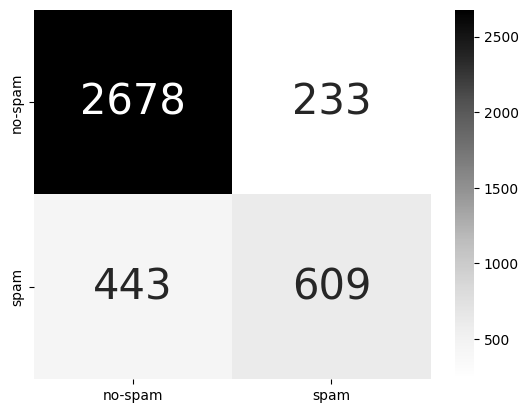

In [16]:
import os
import torch

model_name = "BiLSTM"
model_path = f"../input/vispamreviews-models/{model_name}/{model_name}_(1).pth"
model = BiLSTM(task=1).to(device)
model.load_state_dict(torch.load(model_path))
true_labels, predicts = test(model, test_dataloader, task=1)
test_cm = evaluate(true_labels, predicts)
plotting_confusion_matrix(test_cm, model_name, task=1)

In [17]:
import os
import pandas as pd

predict_df = pd.DataFrame({'comment': vispam_datasets['test']['comment'],
                           'category': vispam_datasets['test']['category'],
                           'description': vispam_datasets['test']['description'],
                           'label': true_labels, 'predict': predicts})
predict_df.to_csv(os.path.join(model_name, f'{model_name}_test_prediction_(1).csv'), index=False)
wrong_df = predict_df[predict_df.label != predict_df.predict]
sorted_df = wrong_df.sort_values(['label', 'predict'], ascending=[False, False])
sorted_df

comment  \
8     Kakaa ba n·∫±m b√™n tr√°i th√¨ e b√© nh√©t qua b√™n tr...   
25    H√†ng ƒë·∫πp . giao r·∫•t ok , ·ªßng h·ªô ·∫° \r\nH√†ng ƒë·∫πp...   
26                  C·∫ßn k√≠ch c√° li√™n h·ªá zalo 0914006498   
34    Giao h√†ng nhanh. H√¨nh ·∫£nh vs video mang t√≠nh c...   
38    Mua bnh c√°i t√∫i ƒë·ª±ng b√†i c≈©ng k bao h l√† ƒë·ªß ·∫•y...   
...                                                 ...   
3895  ƒê·ª£t n√†y giao h√†ng h∆°i l√¢u. ƒê√£ mua c·ªßa shop nhi...   
3896                                T·∫°m th·ªùi l√† d√πng ·ªïn   
3913  Si√™u tooooo\r\nGiao h√†ng si√™u nhanh\r\nH√†ng s·ª≠...   
3940  Tr∆∞·ªõc gi·ªù to√†n ƒÉn v·ªã cay, nay mua th·ª≠ l·∫©u th·∫≠p...   
3945                                 H√†ng t·ªõi h l√† ngon   

                   category  \
8                Th·ªùi Trang   
25                     S√°ch   
26                  ƒêi·ªán T·ª≠   
34       Nh√† C·ª≠a - ƒê·ªùi S·ªëng   
38       Nh√† C·ª≠a - ƒê·ªùi S·ªëng   
...                     ...   
3895             Th·ªùi Trang   
3896                ƒêi·ªán T·ª≠   
3913                ƒêi·ªán T·ª≠   
3940                   Kh√°c   
3945  ƒêi·ªán Thoai - M√°y T√≠nh   

                                            description  label  predict  
8     Qu·∫ßn l√≥t nam thun l·∫°nh nh·∫≠t b·∫£n, qu·∫ßn s·ªãp ƒë√∫c ...      1        0  
25    Th·ªùi gian giao h√†ng d·ª± ki·∫øn cho s·∫£n ph·∫©m n√†y l...      1        0  
26    T√çNH NƒÇNG S·∫¢N PH·∫®M - Opto l√† m·ªôt linh ki·ªán qua...      1        0  
34    5 l∆∞u √Ω tr∆∞·ªõc khi ƒë·∫∑t h√†ng: 1 - Mi·ªÖn ph√≠ v·∫≠n c...      1        0  
38    T√∫i Nhung ƒê∆∞ng Tarot Ti·ªÅn Cao C·∫•p T√∫i v·∫£i nhun...      1        0  
...                                                 ...    ...      ...  
3895  Qu·∫ßn s∆° sinh b√¨nh s·ªØa ƒë∆∞·ª£c l√†m t·ª´ ch·∫•t li·ªáu co...      0        1  
3896  ThieÃÇÃÅt keÃÇÃÅ thaÃÇn thieÃ£ÃÇn Logitech B100 suÃõÃâ ...      0        1  
3913  GIAO HAÃÄNG VAÃÄ LAÃÜÃÅP ƒêAÃ£ÃÜT CUÃÄNG LUÃÅCGiaÃÅ saÃân...      0        1  
3940  üå∂Ô∏èGia V·ªã L·∫©u Haidilao (H·∫£i ƒê·∫ø Lao) Ch·∫Øc h·∫≥n ai...      0        1  
3945  MaÃÄn hiÃÄnh Liquid Retina iPad Air moÃõÃÅi soÃõÃâ h...      0        1  

[676 rows x 5 columns]

Loaded pretrained embeddings, weights are not trainable.


  0%|          | 0/16 [00:00<?, ?it/s]

Accuracy: 0.7837
Precision: 0.6007
Recall: 0.6600
F1-score: 0.6104
Confusion matrix:
 [[2459   35  322   95]
 [  18   28    6    2]
 [  88    2  212    7]
 [ 222   12   48  407]]
              precision    recall  f1-score   support

           0     0.8823    0.8447    0.8631      2911
           1     0.3636    0.5185    0.4275        54
           2     0.3605    0.6861    0.4727       309
           3     0.7965    0.5907    0.6783       689

    accuracy                         0.7837      3963
   macro avg     0.6007    0.6600    0.6104      3963
weighted avg     0.8196    0.7837    0.7946      3963



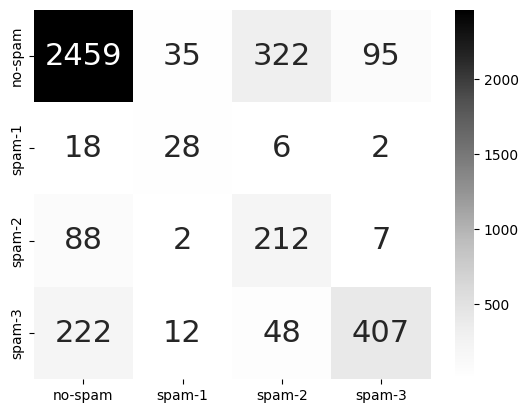

In [18]:
import os
import torch

model_name = "BiLSTM"
model_path = f"../input/vispamreviews-models/{model_name}/{model_name}_(2).pth"
model = BiLSTM(task=2).to(device)
model.load_state_dict(torch.load(model_path))
true_labels, predicts = test(model, test_dataloader, task=2)
test_cm = evaluate(true_labels, predicts)
plotting_confusion_matrix(test_cm, model_name, task=2)

In [19]:
import os
import pandas as pd

predict_df = pd.DataFrame({'comment': vispam_datasets['test']['comment'],
                           'category': vispam_datasets['test']['category'],
                           'description': vispam_datasets['test']['description'],
                           'spam_label': true_labels, 'predict': predicts})
predict_df.to_csv(os.path.join(model_name, f'{model_name}_test_prediction_(2).csv'), index=False)
wrong_df = predict_df[predict_df.spam_label != predict_df.predict]
sorted_df = wrong_df.sort_values(['spam_label', 'predict'], ascending=[False, False])
sorted_df

comment  \
53    h√†ng OK r·ªìi em v·∫´n ƒëang ti·∫øp t·ª•c v√†o vai m·ªôt c...   
226   Giao h√†ng nhanh. S·∫£n ph·∫©m nh∆∞ h√¨nh. S·∫Ω ·ªßng h·ªô ...   
285   Giao ch·∫≠m nhg nhanh nh∆∞ c∆°n gi√≥, ship uy t√≠n n...   
352   Mua cho m·∫π. Hy v·ªçng m·∫π s·∫Ω h·ªçc ƒë∆∞·ª£c ‚ù§Ô∏è‚Äçüî•‚ù§Ô∏è‚Äçüî•‚ù§Ô∏è‚Äç...   
536   Giao h√†ng h∆°i l√¢u, ƒë√≥ng g√≥i ƒë∆∞·ª£c, n√≥i chung c≈©...   
...                                                 ...   
3092  Shop v·∫´n c·ª© l√† d·ªÖ th∆∞∆°ng l·∫Øm\r\nH·ªó tr·ª£ t·ªët, s·∫£...   
3267  S·∫£n ph·∫©m tuy·ªát v·ªùi ch·∫•t l∆∞·ª£ng t·ªët, giao h√†ng n...   
3829  Giao h√†ng nhanh balo ƒë·ªânh lu√¥n v·ªõi gi√° th·∫ø n√†y...   
3879  Ch·∫•t l∆∞·ª£ng s·∫£n ph·∫©m tuy·ªát v·ªùi, giao h√†ng nhanh...   
3914  Shop giao ƒë√∫ng s·∫£n ph·∫©m nh∆∞ m√¥ tar, s·∫£n ph·∫©m ƒë...   

                   category  \
53                     Kh√°c   
226                Th·ªÉ Thao   
285                    Kh√°c   
352                    S√°ch   
536      Nh√† C·ª≠a - ƒê·ªùi S·ªëng   
...                     ...   
3092             Th·ªùi Trang   
3267  ƒêi·ªán Thoai - M√°y T√≠nh   
3829             Th·ªùi Trang   
3879                   S√°ch   
3914             Th·ªùi Trang   

                                            description  spam_label  predict  
53    DaÃÇÃÄu AÃÜn ThuÃõoÃõÃ£ng HaÃ£ng NhaÃÉn HieÃ£ÃÇu Neptune...           3        2  
226   Th√¥ng s·ªë s·∫£n ph·∫©m ‚úîÔ∏èK√≠ch th∆∞·ªõc: 80-130cm/ 60-1...           3        2  
285   H∆Ø·ªöNG D·∫™N MUA TH·∫∫ Viettel 100k ,QU√ù KH√ÅCH VUI ...           3        2  
352   Th∆∞∆°ng hi·ªáu: Nguy·ªÖn VƒÉn Hi·ªáp Nh√† ph√°t h√†nh: C√¥...           3        2  
536   S·∫£n ph·∫©m khƒÉn gi·∫•y ∆∞·ªõt ƒë∆∞·ª£c s·∫£n xu·∫•t t·ª´ nguy√™n...           3        2  
...                                                 ...         ...      ...  
3092  DEAL NG·∫™U NHI√äN KH√îNG L·ª∞A M·∫™U / Kh√°ch l·ª±a m·∫´u ...           0        1  
3267   Tai Nghe Bluetooth Kh√¥ng D√¢y i12 TWS 5.0 √Çm T...           0        1  
3829  Balo Laptop nam n·ªØ Th·ªùi Trang ch·ªëng tr·ªôm, ch·ªën...           0        1  
3879   Th·ªùi gian giao h√†ng d·ª± ki·∫øn cho s·∫£n ph·∫©m n√†y ...           0        1  
3914  VALIZA h·ªó tr·ª£ ƒë·ªïi tr·∫£ trong v√≤ng 3 ng√†y cho c√°...           0        1  

[857 rows x 5 columns]

# BiGRU

Loaded pretrained embeddings, weights are not trainable.


  0%|          | 0/16 [00:00<?, ?it/s]

Accuracy: 0.8312
Precision: 0.7856
Recall: 0.7725
F1-score: 0.7786
Confusion matrix:
 [[2613  298]
 [ 371  681]]
              precision    recall  f1-score   support

           0     0.8757    0.8976    0.8865      2911
           1     0.6956    0.6473    0.6706      1052

    accuracy                         0.8312      3963
   macro avg     0.7856    0.7725    0.7786      3963
weighted avg     0.8279    0.8312    0.8292      3963



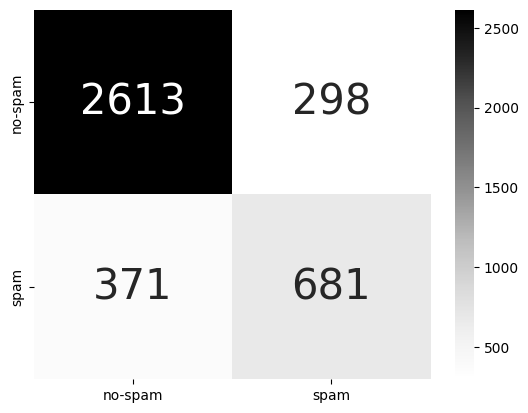

In [20]:
import os
import torch

model_name = "BiGRU"
model_path = f"../input/vispamreviews-models/{model_name}/{model_name}_(1).pth"
model = BiGRU(task=1).to(device)
model.load_state_dict(torch.load(model_path))
true_labels, predicts = test(model, test_dataloader, task=1)
test_cm = evaluate(true_labels, predicts)
plotting_confusion_matrix(test_cm, model_name, task=1)

In [21]:
import os
import pandas as pd

predict_df = pd.DataFrame({'comment': vispam_datasets['test']['comment'],
                           'category': vispam_datasets['test']['category'],
                           'description': vispam_datasets['test']['description'],
                           'label': true_labels, 'predict': predicts})
predict_df.to_csv(os.path.join(model_name, f'{model_name}_test_prediction_(1).csv'), index=False)
wrong_df = predict_df[predict_df.label != predict_df.predict]
sorted_df = wrong_df.sort_values(['label', 'predict'], ascending=[False, False])
sorted_df

comment  \
8     Kakaa ba n·∫±m b√™n tr√°i th√¨ e b√© nh√©t qua b√™n tr...   
25    H√†ng ƒë·∫πp . giao r·∫•t ok , ·ªßng h·ªô ·∫° \r\nH√†ng ƒë·∫πp...   
26                  C·∫ßn k√≠ch c√° li√™n h·ªá zalo 0914006498   
38    Mua bnh c√°i t√∫i ƒë·ª±ng b√†i c≈©ng k bao h l√† ƒë·ªß ·∫•y...   
44    Kh√¥ng ch·ª•p ·∫£nh ƒë∆∞·ª£c s·∫£n ph·∫©m n√™n m√¨nh l·∫•y t·∫°m ...   
...                                                 ...   
3913  Si√™u tooooo\r\nGiao h√†ng si√™u nhanh\r\nH√†ng s·ª≠...   
3918  Giao h√†ng nhanh ƒë√£ nh·∫≠n ƒë∆∞·ª£c h√†ng. Kh√° v·ª´a √Ω. ...   
3937  Giao h√†ng nhanh, ƒë√≥ng g√≥i c·∫©n th·∫≠n. H√†ng ch·∫•t ...   
3943  quay laÃ£i mua l√¢ÃÄn th∆∞ÃÅ 4 .c∆∞ÃÅ m√¥ÃÉi l√¢ÃÄn laÃ£i ...   
3945                                 H√†ng t·ªõi h l√† ngon   

                   category  \
8                Th·ªùi Trang   
25                     S√°ch   
26                  ƒêi·ªán T·ª≠   
38       Nh√† C·ª≠a - ƒê·ªùi S·ªëng   
44                  M√°y ·∫¢nh   
...                     ...   
3913                ƒêi·ªán T·ª≠   
3918               Th·ªÉ Thao   
3937             Th·ªùi Trang   
3943     Nh√† C·ª≠a - ƒê·ªùi S·ªëng   
3945  ƒêi·ªán Thoai - M√°y T√≠nh   

                                            description  label  predict  
8     Qu·∫ßn l√≥t nam thun l·∫°nh nh·∫≠t b·∫£n, qu·∫ßn s·ªãp ƒë√∫c ...      1        0  
25    Th·ªùi gian giao h√†ng d·ª± ki·∫øn cho s·∫£n ph·∫©m n√†y l...      1        0  
26    T√çNH NƒÇNG S·∫¢N PH·∫®M - Opto l√† m·ªôt linh ki·ªán qua...      1        0  
38    T√∫i Nhung ƒê∆∞ng Tarot Ti·ªÅn Cao C·∫•p T√∫i v·∫£i nhun...      1        0  
44    ƒê·∫∑c t√≠nh ∆∞u Vi·ªát c·ªßa Camera Yoosee Ti·∫øng Vi·ªát ...      1        0  
...                                                 ...    ...      ...  
3913  GIAO HAÃÄNG VAÃÄ LAÃÜÃÅP ƒêAÃ£ÃÜT CUÃÄNG LUÃÅCGiaÃÅ saÃân...      0        1  
3918  TH√îNG TIN S·∫¢N PH·∫®M - S·∫£n ph·∫©m: T·∫•t c·ªï ng·∫Øn - C...      0        1  
3937  GI·ªöI THI·ªÜU S·∫¢N PH·∫®M : T·∫•t nam n·ªØ c·ªï cao tr·∫Øng ...      0        1  
3943  NguÃâ ngon vaÃÄ saÃÇu hoÃõn voÃõÃÅi suÃõÃ£ naÃÇng ƒëoÃõÃÉ ...      0        1  
3945  MaÃÄn hiÃÄnh Liquid Retina iPad Air moÃõÃÅi soÃõÃâ h...      0        1  

[669 rows x 5 columns]

Loaded pretrained embeddings, weights are not trainable.


  0%|          | 0/16 [00:00<?, ?it/s]

Accuracy: 0.7744
Precision: 0.5704
Recall: 0.6909
F1-score: 0.6095
Confusion matrix:
 [[2311   45  355  200]
 [  15   29    5    5]
 [  73    2  210   24]
 [ 128   14   28  519]]
              precision    recall  f1-score   support

           0     0.9145    0.7939    0.8499      2911
           1     0.3222    0.5370    0.4028        54
           2     0.3512    0.6796    0.4631       309
           3     0.6939    0.7533    0.7223       689

    accuracy                         0.7744      3963
   macro avg     0.5704    0.6909    0.6095      3963
weighted avg     0.8242    0.7744    0.7915      3963



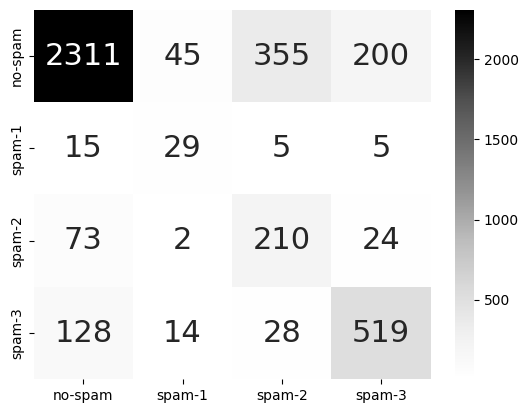

In [22]:
import os
import torch

model_name = "BiGRU"
model_path = f"../input/vispamreviews-models/{model_name}/{model_name}_(2).pth"
model = BiGRU(task=2).to(device)
model.load_state_dict(torch.load(model_path))
true_labels, predicts = test(model, test_dataloader, task=2)
test_cm = evaluate(true_labels, predicts)
plotting_confusion_matrix(test_cm, model_name, task=2)

In [23]:
import os
import pandas as pd

predict_df = pd.DataFrame({'comment': vispam_datasets['test']['comment'],
                           'category': vispam_datasets['test']['category'],
                           'description': vispam_datasets['test']['description'],
                           'spam_label': true_labels, 'predict': predicts})
predict_df.to_csv(os.path.join(model_name, f'{model_name}_test_prediction_(2).csv'), index=False)
wrong_df = predict_df[predict_df.spam_label != predict_df.predict]
sorted_df = wrong_df.sort_values(['spam_label', 'predict'], ascending=[False, False])
sorted_df

comment            category  \
285   Giao ch·∫≠m nhg nhanh nh∆∞ c∆°n gi√≥, ship uy t√≠n n...                Kh√°c   
536   Giao h√†ng h∆°i l√¢u, ƒë√≥ng g√≥i ƒë∆∞·ª£c, n√≥i chung c≈©...  Nh√† C·ª≠a - ƒê·ªùi S·ªëng   
586   shop giao h√†ng nhanh, chu ƒë√°o, c·∫©n th·∫≠n r·∫•t h√†...             ƒê·ªì Ch∆°i   
628   Giao h√†ng nhanh ch√≥ng,bbdbfbfjfjhfbfhfhhfjfhfh...  Nh√† C·ª≠a - ƒê·ªùi S·ªëng   
700   CaÃâm oÃõn b ƒëaÃÉ tin tuÃõoÃõÃâng vaÃÄ uÃâng hoÃ£ÃÇ kiÃÅn...                Kh√°c   
...                                                 ...                 ...   
3433  S·∫£n ph·∫©m m·ªèng h∆°n d√¢y m√¨nh ƒë√£ mua ch·ªó kh√°c nh∆∞...             ƒêi·ªán T·ª≠   
3821  Shop ph·ª•c v·ª• r·∫•t t·ªët. R·∫•t ƒë√°ng ti·ªÅn. Th·ªùi gian...          Th·ªùi Trang   
3829  Giao h√†ng nhanh balo ƒë·ªânh lu√¥n v·ªõi gi√° th·∫ø n√†y...          Th·ªùi Trang   
3879  Ch·∫•t l∆∞·ª£ng s·∫£n ph·∫©m tuy·ªát v·ªùi, giao h√†ng nhanh...                S√°ch   
3914  Shop giao ƒë√∫ng s·∫£n ph·∫©m nh∆∞ m√¥ tar, s·∫£n ph·∫©m ƒë...          Th·ªùi Trang   

                                            description  spam_label  predict  
285   H∆Ø·ªöNG D·∫™N MUA TH·∫∫ Viettel 100k ,QU√ù KH√ÅCH VUI ...           3        2  
536   S·∫£n ph·∫©m khƒÉn gi·∫•y ∆∞·ªõt ƒë∆∞·ª£c s·∫£n xu·∫•t t·ª´ nguy√™n...           3        2  
586   M√°y T·∫°o Ti·∫øng ·ªín Tr·∫Øng Gi√∫p b√© ng·ªß ngon, s√¢u g...           3        2  
628   Cam k·∫øt: - H√†ng chu·∫©n c√¥ng ty, d√†y ƒë·∫πp - Kh√¥ng...           3        2  
700   [E-voucher] M√£ mua h√†ng Shopee (tr∆∞ÃÄ NaÃ£p TheÃâ...           3        2  
...                                                 ...         ...      ...  
3433  d√¢y c·∫•p (d√¢y to) v√† d√¢y th·∫£i (d√¢y nh·ªè)d√πng cho...           0        1  
3821  Th·ªùi gian giao h√†ng d·ª± ki·∫øn cho s·∫£n ph·∫©m n√†y l...           0        1  
3829  Balo Laptop nam n·ªØ Th·ªùi Trang ch·ªëng tr·ªôm, ch·ªën...           0        1  
3879   Th·ªùi gian giao h√†ng d·ª± ki·∫øn cho s·∫£n ph·∫©m n√†y ...           0        1  
3914  VALIZA h·ªó tr·ª£ ƒë·ªïi tr·∫£ trong v√≤ng 3 ng√†y cho c√°...           0        1  

[894 rows x 5 columns]

In [24]:
import numpy as np
import torch
import torch.nn.functional as F

class_names = ['no-spam', 'spam']
spam_class_names = ['no-spam', 'spam-1', 'spam-2', 'spam-3']

def encode_text(text, word2idx, max_len=100):
    tokenized_text = word_tokenize(text)
    if len(tokenized_text) > max_len:
        tokenized_text = tokenized_text[:max_len]
    tokenized_text += ['<pad>'] * (max_len - len(tokenized_text))
    input_id = [word2idx.get(token, word2idx['<unk>']) for token in tokenized_text]
    return np.array(input_id)

def inference(model, text, word2idx, task=1):
    model.eval()
    
    input_ids = encode_text(text, word2idx, max_len=100)
    input_ids = torch.tensor(input_ids).unsqueeze(0).to(device)
    with torch.no_grad():
        outputs = model(input_ids)
    predict_label = torch.argmax(outputs, dim=1)[0]
    probability = F.softmax(outputs, dim=1)[0][predict_label]
    
    print(f'Sentence: {text}')
    print(f'Predict: {class_names[predict_label] if task == 1 else spam_class_names[predict_label]}')
    print(f'Probability: {round(probability.cpu().item(), 4)}')

In [25]:
task = 2
model_name = "TextCNN"

if model_name == "TextCNN":
    model = TextCNN(task).to(device)
elif model_name == "BiLSTM":
    model = BiLSTM(task).to(device)
else:
    model = BiGRU(task).to(device)
model_path = f"../input/vispamreviews-models/{model_name}/{model_name}_(2).pth"
model.load_state_dict(torch.load(model_path))

comment = 'Ch∆∞a d√πng n√™n ch∆∞a bi·∫øt th·∫ø n√†o n·ªØa'
inference(model, comment, word2idx, task)

Loaded pretrained embeddings, weights are not trainable.
Sentence: Ch∆∞a d√πng n√™n ch∆∞a bi·∫øt th·∫ø n√†o n·ªØa
Predict: spam-2
Probability: 0.9731


# PhoBERT

In [26]:
from torch import nn
from transformers import AutoModel, BertModel

class ViSpam_Classifier(nn.Module):
    
    def __init__(self, model_name, task, freeze_bert=False, drop=0.3):
        super(ViSpam_Classifier, self).__init__()
        
        assert model_name in ['PhoBERT', 'BERT4News', 'ViBERT']
        
        self.model_name = model_name
        self.task = task
        self.num_classes = 2 if task == 1 else 4
        
        if model_name == 'PhoBERT':
            self.bert = AutoModel.from_pretrained('vinai/phobert-base')
        elif model_name == 'BERT4News':
            self.bert = BertModel.from_pretrained('NlpHUST/vibert4news-base-cased')
        else:
            self.bert = AutoModel.from_pretrained('FPTAI/vibert-base-cased')
            
        if freeze_bert:
            for param in self.bert.parameters():
                param.requires_grad = False
        
        self.drop = nn.Dropout(drop)
        self.fc = nn.Linear(self.bert.config.hidden_size, self.num_classes)
        # nn.init.normal_(self.fc.weight, std=0.02)
        # nn.init.normal_(self.fc.bias, 0)
        
    def forward(self, input_ids, attention_mask):
        last_hidden_state, output = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask,
            return_dict=False
        )
        x = self.drop(output)
        x = self.fc(x)
        return x
    
    
def test(model, dataloader, task):
    model.eval()
    predicts = []
    predict_probs = []
    true_labels = []
    
    label_column = 'label' if task == 1 else 'spam_label'

    for data in tqdm(dataloader):
        input_ids = data['input_ids'].to(device)
        attention_mask = data['attention_mask'].to(device)
        labels = data[label_column].to(device)
        
        with torch.no_grad():
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            
        pred = torch.max(outputs, dim=1)[1]
        predicts.extend(pred.cpu().data.numpy())
        predict_probs.extend(outputs.cpu().data.numpy())
        true_labels.extend(labels.cpu().data.numpy())
        
    return true_labels, predicts

In [27]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base")

def encode_data(examples):
    return tokenizer(examples["clean_tokenized_comment"], padding="max_length", max_length=100, truncation=True, add_special_tokens=True)

encoded_datasets = vispam_datasets.map(encode_data, batched=True)
encoded_datasets = encoded_datasets.remove_columns(vispam_datasets['train'].column_names[:-2])
encoded_datasets.set_format("torch")

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


  0%|          | 0/15 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/4 [00:00<?, ?ba/s]

In [28]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(encoded_datasets['train'], shuffle=True, batch_size=16)
val_dataloader = DataLoader(encoded_datasets['dev'], batch_size=16)
test_dataloader = DataLoader(encoded_datasets['test'], batch_size=16)

Some weights of the model checkpoint at vinai/phobert-base were not used when initializing RobertaModel: ['lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.bias', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/248 [00:00<?, ?it/s]

Accuracy: 0.8923
Precision: 0.8740
Recall: 0.8417
F1-score: 0.8558
Confusion matrix:
 [[2764  147]
 [ 280  772]]
              precision    recall  f1-score   support

           0     0.9080    0.9495    0.9283      2911
           1     0.8400    0.7338    0.7834      1052

    accuracy                         0.8923      3963
   macro avg     0.8740    0.8417    0.8558      3963
weighted avg     0.8900    0.8923    0.8898      3963



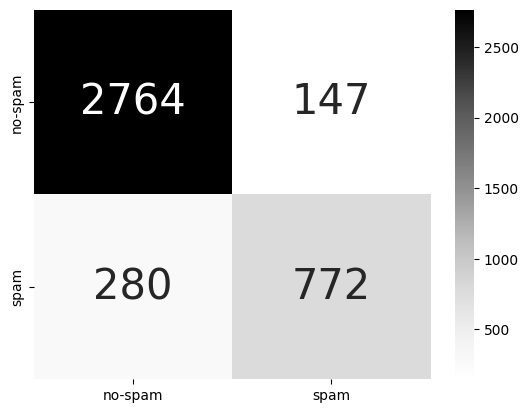

In [29]:
import os
import torch

model_name = "PhoBERT"
model_path = f"../input/vispamreviews-models/{model_name}/{model_name}_(1).pth"
model = ViSpam_Classifier(model_name, task=1).to(device)
model.load_state_dict(torch.load(model_path))
true_labels, predicts = test(model, test_dataloader, task=1)
test_cm = evaluate(true_labels, predicts)
plotting_confusion_matrix(test_cm, model_name, task=1)

In [30]:
import os
import pandas as pd

predict_df = pd.DataFrame({'comment': vispam_datasets['test']['comment'],
                           'category': vispam_datasets['test']['category'],
                           'description': vispam_datasets['test']['description'],
                           'label': true_labels, 'predict': predicts})
predict_df.to_csv(os.path.join(model_name, f'{model_name}_test_prediction_(1).csv'), index=False)
wrong_df = predict_df[predict_df.label != predict_df.predict]
sorted_df = wrong_df.sort_values(['label', 'predict'], ascending=[False, False])
sorted_df

comment            category  \
8     Kakaa ba n·∫±m b√™n tr√°i th√¨ e b√© nh√©t qua b√™n tr...          Th·ªùi Trang   
25    H√†ng ƒë·∫πp . giao r·∫•t ok , ·ªßng h·ªô ·∫° \r\nH√†ng ƒë·∫πp...                S√°ch   
38    Mua bnh c√°i t√∫i ƒë·ª±ng b√†i c≈©ng k bao h l√† ƒë·ªß ·∫•y...  Nh√† C·ª≠a - ƒê·ªùi S·ªëng   
44    Kh√¥ng ch·ª•p ·∫£nh ƒë∆∞·ª£c s·∫£n ph·∫©m n√™n m√¨nh l·∫•y t·∫°m ...             M√°y ·∫¢nh   
53    h√†ng OK r·ªìi em v·∫´n ƒëang ti·∫øp t·ª•c v√†o vai m·ªôt c...                Kh√°c   
...                                                 ...                 ...   
3840  D√¢y y h√¨nh\r\nƒê√≥ng g√≥i c·∫¢n th·∫≠n\r\nS·∫Ω ·ªßng h·ªô s...            Th·ªÉ Thao   
3879  Ch·∫•t l∆∞·ª£ng s·∫£n ph·∫©m tuy·ªát v·ªùi, giao h√†ng nhanh...                S√°ch   
3895  ƒê·ª£t n√†y giao h√†ng h∆°i l√¢u. ƒê√£ mua c·ªßa shop nhi...          Th·ªùi Trang   
3896                                T·∫°m th·ªùi l√† d√πng ·ªïn             ƒêi·ªán T·ª≠   
3913  Si√™u tooooo\r\nGiao h√†ng si√™u nhanh\r\nH√†ng s·ª≠...             ƒêi·ªán T·ª≠   

                                            description  label  predict  
8     Qu·∫ßn l√≥t nam thun l·∫°nh nh·∫≠t b·∫£n, qu·∫ßn s·ªãp ƒë√∫c ...      1        0  
25    Th·ªùi gian giao h√†ng d·ª± ki·∫øn cho s·∫£n ph·∫©m n√†y l...      1        0  
38    T√∫i Nhung ƒê∆∞ng Tarot Ti·ªÅn Cao C·∫•p T√∫i v·∫£i nhun...      1        0  
44    ƒê·∫∑c t√≠nh ∆∞u Vi·ªát c·ªßa Camera Yoosee Ti·∫øng Vi·ªát ...      1        0  
53    DaÃÇÃÄu AÃÜn ThuÃõoÃõÃ£ng HaÃ£ng NhaÃÉn HieÃ£ÃÇu Neptune...      1        0  
...                                                 ...    ...      ...  
3840  üëâSPORT 247 cam k·∫øt gi√° b√°n r·∫ª nh·∫•t shopee ·ªü ƒë√¢...      0        1  
3879   Th·ªùi gian giao h√†ng d·ª± ki·∫øn cho s·∫£n ph·∫©m n√†y ...      0        1  
3895  Qu·∫ßn s∆° sinh b√¨nh s·ªØa ƒë∆∞·ª£c l√†m t·ª´ ch·∫•t li·ªáu co...      0        1  
3896  ThieÃÇÃÅt keÃÇÃÅ thaÃÇn thieÃ£ÃÇn Logitech B100 suÃõÃâ ...      0        1  
3913  GIAO HAÃÄNG VAÃÄ LAÃÜÃÅP ƒêAÃ£ÃÜT CUÃÄNG LUÃÅCGiaÃÅ saÃân...      0        1  

[427 rows x 5 columns]

Some weights of the model checkpoint at vinai/phobert-base were not used when initializing RobertaModel: ['lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.bias', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/248 [00:00<?, ?it/s]

Accuracy: 0.8779
Precision: 0.7185
Recall: 0.7142
F1-score: 0.7156
Confusion matrix:
 [[2700   21  105   85]
 [  16   31    0    7]
 [ 147    0  151   11]
 [  72    5   15  597]]
              precision    recall  f1-score   support

           0     0.9199    0.9275    0.9237      2911
           1     0.5439    0.5741    0.5586        54
           2     0.5572    0.4887    0.5207       309
           3     0.8529    0.8665    0.8596       689

    accuracy                         0.8779      3963
   macro avg     0.7185    0.7142    0.7156      3963
weighted avg     0.8749    0.8779    0.8762      3963



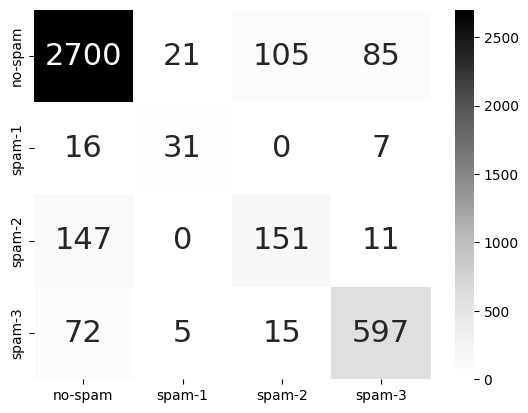

In [31]:
import os
import torch

model_name = "PhoBERT"
model_path = f"../input/vispamreviews-models/{model_name}/{model_name}_(2).pth"
model = ViSpam_Classifier(model_name, task=2).to(device)
model.load_state_dict(torch.load(model_path))
true_labels, predicts = test(model, test_dataloader, task=2)
test_cm = evaluate(true_labels, predicts)
plotting_confusion_matrix(test_cm, model_name, task=2)

In [32]:
import os
import pandas as pd

predict_df = pd.DataFrame({'comment': vispam_datasets['test']['comment'],
                           'category': vispam_datasets['test']['category'],
                           'description': vispam_datasets['test']['description'],
                           'spam_label': true_labels, 'predict': predicts})
predict_df.to_csv(os.path.join(model_name, f'{model_name}_test_prediction_(2).csv'), index=False)
wrong_df = predict_df[predict_df.spam_label != predict_df.predict]
sorted_df = wrong_df.sort_values(['spam_label', 'predict'], ascending=[False, False])
sorted_df

comment  \
766                                           giao h√†ng   
805                           Shop k·∫øt n·ªëi sao v·∫≠y shop   
1005  ƒê·∫∑t 8 c·ª≠a shop giao c√≥ 5 c·ª≠a nt shop k ph·∫£n h·ªì...   
1477                              D√°n tem l·∫°i cho chƒÉc!   
1509  Vui l√≤ng ƒëƒÉng nh·∫≠p Shopee ƒë·ªÉ x√°c nh·∫≠n b·∫°n ƒë√£ n...   
...                                                 ...   
2826  Ch·∫•t l∆∞·ª£ng s·∫£n ph·∫©m tuy·ªát v·ªùi , giao h√†ng nhan...   
2909                  Ch·∫•t l∆∞·ª£ng s·∫£n ph·∫©m tuy·ªát v·ªùi, m√°   
3267  S·∫£n ph·∫©m tuy·ªát v·ªùi ch·∫•t l∆∞·ª£ng t·ªët, giao h√†ng n...   
3446  Giao h√†ng nhanh , ch·∫•t l∆∞·ª£ng s·∫£n ph·∫©m r·∫•t tuy·ªá...   
3879  Ch·∫•t l∆∞·ª£ng s·∫£n ph·∫©m tuy·ªát v·ªùi, giao h√†ng nhanh...   

                   category  \
766                    Kh√°c   
805                 M√°y ·∫¢nh   
1005               Th·ªÉ Thao   
1477  ƒêi·ªán Thoai - M√°y T√≠nh   
1509               Th·ªÉ Thao   
...                     ...   
2826            Ph∆∞∆°ng Ti·ªán   
2909                ƒêi·ªán T·ª≠   
3267  ƒêi·ªán Thoai - M√°y T√≠nh   
3446  ƒêi·ªán Thoai - M√°y T√≠nh   
3879                   S√°ch   

                                            description  spam_label  predict  
766   LUÃõU YÃÅ: Bao BiÃÄ SaÃân phaÃÇÃâm coÃÅ theÃÇÃâ thay ƒëo...           3        2  
805   * SaÃân phaÃÇÃâm coÃÅ 3 thuoÃ£ÃÇc tiÃÅnh luÃõÃ£a choÃ£n,...           3        2  
1005  Gi·ªõi thi·ªáu s·∫£n ph·∫©m L∆∞·ªõi b√°t qu√°i ƒë√°nh b·∫Øt c√° ...           3        2  
1477  GioÃõÃÅi thieÃ£ÃÇu saÃân phaÃÇÃâm USB Sandisk Ultra L...           3        2  
1509  D∆Ø∆†NG SPORT t·ª± h√†o l√† ƒë∆°n v·ªã cung c·∫•p ph·ª• ki·ªán...           3        2  
...                                                 ...         ...      ...  
2826  Ch·∫•t Li·ªáu : Titan ƒê·∫∑c T√≠nh : L√† H·ª£p Kim C·ª©ng H...           0        1  
2909  ThieÃÇÃÅt keÃÇÃÅ hieÃ£ÃÇn ƒëaÃ£i, tinh teÃÇÃÅ MaÃÅy laÃ£nh...           0        1  
3267   Tai Nghe Bluetooth Kh√¥ng D√¢y i12 TWS 5.0 √Çm T...           0        1  
3446   *M√°y in ƒë∆°n h√†ng TMƒêT SP46 c·ªßa Shoptida - Nha...           0        1  
3879   Th·ªùi gian giao h√†ng d·ª± ki·∫øn cho s·∫£n ph·∫©m n√†y ...           0        1  

[484 rows x 5 columns]

# BERT4News

In [33]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained("NlpHUST/vibert4news-base-cased")

def encode_data(examples):
    return tokenizer(examples["clean_comment"], padding="max_length", max_length=100, truncation=True, add_special_tokens=True)

encoded_datasets = vispam_datasets.map(encode_data, batched=True)
encoded_datasets = encoded_datasets.remove_columns(vispam_datasets['train'].column_names[:-2])
encoded_datasets.set_format("torch")

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'RobertaTokenizer'. 
The class this function is called from is 'BertTokenizer'.


  0%|          | 0/15 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/4 [00:00<?, ?ba/s]

In [34]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(encoded_datasets['train'], shuffle=True, batch_size=16)
val_dataloader = DataLoader(encoded_datasets['dev'], batch_size=16)
test_dataloader = DataLoader(encoded_datasets['test'], batch_size=16)

Some weights of the model checkpoint at NlpHUST/vibert4news-base-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/248 [00:00<?, ?it/s]

Accuracy: 0.8849
Precision: 0.8535
Recall: 0.8500
F1-score: 0.8518
Confusion matrix:
 [[2691  220]
 [ 236  816]]
              precision    recall  f1-score   support

           0     0.9194    0.9244    0.9219      2911
           1     0.7876    0.7757    0.7816      1052

    accuracy                         0.8849      3963
   macro avg     0.8535    0.8500    0.8518      3963
weighted avg     0.8844    0.8849    0.8847      3963



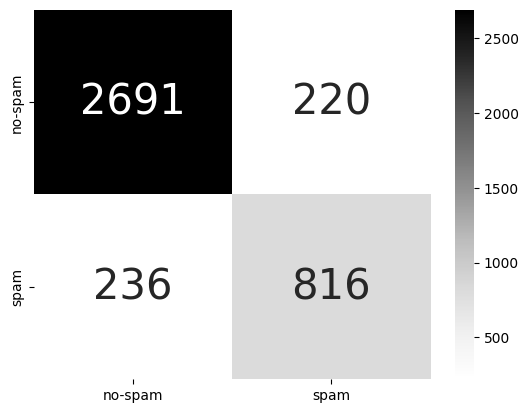

In [35]:
import os
import torch

model_name = "BERT4News"
model_path = f"../input/vispamreviews-models/{model_name}/{model_name}_(1).pth"
model = ViSpam_Classifier(model_name, task=1).to(device)
model.load_state_dict(torch.load(model_path))
true_labels, predicts = test(model, test_dataloader, task=1)
test_cm = evaluate(true_labels, predicts)
plotting_confusion_matrix(test_cm, model_name, task=1)

In [36]:
import os
import pandas as pd

predict_df = pd.DataFrame({'comment': vispam_datasets['test']['comment'],
                           'category': vispam_datasets['test']['category'],
                           'description': vispam_datasets['test']['description'],
                           'label': true_labels, 'predict': predicts})
predict_df.to_csv(os.path.join(model_name, f'{model_name}_test_prediction_(1).csv'), index=False)
wrong_df = predict_df[predict_df.label != predict_df.predict]
sorted_df = wrong_df.sort_values(['label', 'predict'], ascending=[False, False])
sorted_df

comment  \
12    ‚ù§‚ù§Khuy·∫øn mai g√≥i v120‚ù§Ô∏è‚ù§Ô∏è\r\nGi√° l·∫ª 120k/ th√°n...   
25    H√†ng ƒë·∫πp . giao r·∫•t ok , ·ªßng h·ªô ·∫° \r\nH√†ng ƒë·∫πp...   
38    Mua bnh c√°i t√∫i ƒë·ª±ng b√†i c≈©ng k bao h l√† ƒë·ªß ·∫•y...   
44    Kh√¥ng ch·ª•p ·∫£nh ƒë∆∞·ª£c s·∫£n ph·∫©m n√™n m√¨nh l·∫•y t·∫°m ...   
59    H√†ng ·∫° g·ªüi b√†i v√†o v√†o ƒë√¢y ·∫° g·ª≠i g·ª≠i v√†o t√∫i n...   
...                                                 ...   
3862  Shop g√≥i h√†ng c·∫©n th·∫≠n n√™n ƒëƒ©a kh√¥ng b·ªã g√£y ha...   
3873                  H√†ng ch·∫Æc ch·∫Øn, giao h√†ng nhanh.    
3879  Ch·∫•t l∆∞·ª£ng s·∫£n ph·∫©m tuy·ªát v·ªùi, giao h√†ng nhanh...   
3896                                T·∫°m th·ªùi l√† d√πng ·ªïn   
3913  Si√™u tooooo\r\nGiao h√†ng si√™u nhanh\r\nH√†ng s·ª≠...   

                   category  \
12       Nh√† C·ª≠a - ƒê·ªùi S·ªëng   
25                     S√°ch   
38       Nh√† C·ª≠a - ƒê·ªùi S·ªëng   
44                  M√°y ·∫¢nh   
59               Th·ªùi Trang   
...                     ...   
3862  ƒêi·ªán Thoai - M√°y T√≠nh   
3873                ƒêi·ªán T·ª≠   
3879                   S√°ch   
3896                ƒêi·ªán T·ª≠   
3913                ƒêi·ªán T·ª≠   

                                            description  label  predict  
12    """""""1/ N∆Ø·ªöC GI·∫∂T OMO MATIC CHO QU·∫¶N √ÅO B√â Y...      1        0  
25    Th·ªùi gian giao h√†ng d·ª± ki·∫øn cho s·∫£n ph·∫©m n√†y l...      1        0  
38    T√∫i Nhung ƒê∆∞ng Tarot Ti·ªÅn Cao C·∫•p T√∫i v·∫£i nhun...      1        0  
44    ƒê·∫∑c t√≠nh ∆∞u Vi·ªát c·ªßa Camera Yoosee Ti·∫øng Vi·ªát ...      1        0  
59    Th·ªùi gian giao h√†ng d·ª± ki·∫øn cho s·∫£n ph·∫©m n√†y l...      1        0  
...                                                 ...    ...      ...  
3862  S·∫¢N PH·∫®M BAO G·ªíM 1 ƒêƒ®A V√Ä 1 BAO ƒê·ª∞NG ƒêƒ®A . N·∫æU...      0        1  
3873  1./ th√¥ng s·ªë k·ªπ thu·∫≠t: B·ªô nh·ªõ trong 32GB H·ªó tr...      0        1  
3879   Th·ªùi gian giao h√†ng d·ª± ki·∫øn cho s·∫£n ph·∫©m n√†y ...      0        1  
3896  ThieÃÇÃÅt keÃÇÃÅ thaÃÇn thieÃ£ÃÇn Logitech B100 suÃõÃâ ...      0        1  
3913  GIAO HAÃÄNG VAÃÄ LAÃÜÃÅP ƒêAÃ£ÃÜT CUÃÄNG LUÃÅCGiaÃÅ saÃân...      0        1  

[456 rows x 5 columns]

Some weights of the model checkpoint at NlpHUST/vibert4news-base-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/248 [00:00<?, ?it/s]

Accuracy: 0.8824
Precision: 0.7616
Recall: 0.6971
F1-score: 0.7256
Confusion matrix:
 [[2769   13   75   54]
 [  16   31    1    6]
 [ 161    0  141    7]
 [ 112    4   17  556]]
              precision    recall  f1-score   support

           0     0.9055    0.9512    0.9278      2911
           1     0.6458    0.5741    0.6078        54
           2     0.6026    0.4563    0.5193       309
           3     0.8925    0.8070    0.8476       689

    accuracy                         0.8824      3963
   macro avg     0.7616    0.6971    0.7256      3963
weighted avg     0.8761    0.8824    0.8776      3963



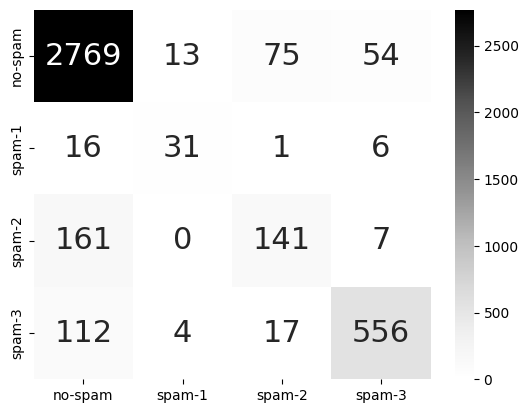

In [37]:
import os
import torch

model_name = "BERT4News"
model_path = f"../input/vispamreviews-models/{model_name}/{model_name}_(2).pth"
model = ViSpam_Classifier(model_name, task=2).to(device)
model.load_state_dict(torch.load(model_path))
true_labels, predicts = test(model, test_dataloader, task=2)
test_cm = evaluate(true_labels, predicts)
plotting_confusion_matrix(test_cm, model_name, task=2)

In [38]:
import os
import pandas as pd

predict_df = pd.DataFrame({'comment': vispam_datasets['test']['comment'],
                           'category': vispam_datasets['test']['category'],
                           'description': vispam_datasets['test']['description'],
                           'spam_label': true_labels, 'predict': predicts})
predict_df.to_csv(os.path.join(model_name, f'{model_name}_test_prediction_(2).csv'), index=False)
wrong_df = predict_df[predict_df.spam_label != predict_df.predict]
sorted_df = wrong_df.sort_values(['spam_label', 'predict'], ascending=[False, False])
sorted_df

comment  \
59    H√†ng ·∫° g·ªüi b√†i v√†o v√†o ƒë√¢y ·∫° g·ª≠i g·ª≠i v√†o t√∫i n...   
440                      ƒê∆∞·ª£c t·∫∑ng k·∫πp t√≥c xinh l·∫Øm nha   
700   CaÃâm oÃõn b ƒëaÃÉ tin tuÃõoÃõÃâng vaÃÄ uÃâng hoÃ£ÃÇ kiÃÅn...   
766                                           giao h√†ng   
1477                              D√°n tem l·∫°i cho chƒÉc!   
...                                                 ...   
1660  ch·∫•t l∆∞·ª£ng s·∫£n ph·∫©m tuy·ªát v·ªùi, ƒë√≥ng g√≥i s·∫£n ph...   
2732  Ch·∫•t l∆∞·ª£ng s·∫£n ph·∫©m tuy·ªát v·ªùi. ƒê√≥ng g√≥i s·∫£n ph...   
2826  Ch·∫•t l∆∞·ª£ng s·∫£n ph·∫©m tuy·ªát v·ªùi , giao h√†ng nhan...   
3829  Giao h√†ng nhanh balo ƒë·ªânh lu√¥n v·ªõi gi√° th·∫ø n√†y...   
3879  Ch·∫•t l∆∞·ª£ng s·∫£n ph·∫©m tuy·ªát v·ªùi, giao h√†ng nhanh...   

                   category  \
59               Th·ªùi Trang   
440                 S·∫Øc ƒê·∫πp   
700                    Kh√°c   
766                    Kh√°c   
1477  ƒêi·ªán Thoai - M√°y T√≠nh   
...                     ...   
1660     Nh√† C·ª≠a - ƒê·ªùi S·ªëng   
2732             Th·ªùi Trang   
2826            Ph∆∞∆°ng Ti·ªán   
3829             Th·ªùi Trang   
3879                   S√°ch   

                                            description  spam_label  predict  
59    Th·ªùi gian giao h√†ng d·ª± ki·∫øn cho s·∫£n ph·∫©m n√†y l...           3        2  
440   Son OfeÃÅlia x Miracle Apo Flawsome Glow Lip la...           3        2  
700   [E-voucher] M√£ mua h√†ng Shopee (tr∆∞ÃÄ NaÃ£p TheÃâ...           3        2  
766   LUÃõU YÃÅ: Bao BiÃÄ SaÃân phaÃÇÃâm coÃÅ theÃÇÃâ thay ƒëo...           3        2  
1477  GioÃõÃÅi thieÃ£ÃÇu saÃân phaÃÇÃâm USB Sandisk Ultra L...           3        2  
...                                                 ...         ...      ...  
1660  TH√îNG S·ªê Kƒ® THU·∫¨T - ƒêi·ªán √°p: 12VDC. - Ch·∫•t li·ªá...           0        1  
2732  T√∫i Zip ƒê·ª±ng ƒê·ªì Trong Su·ªët Nhi·ªÅu Size Ho·∫° Ti·∫øt...           0        1  
2826  Ch·∫•t Li·ªáu : Titan ƒê·∫∑c T√≠nh : L√† H·ª£p Kim C·ª©ng H...           0        1  
3829  Balo Laptop nam n·ªØ Th·ªùi Trang ch·ªëng tr·ªôm, ch·ªën...           0        1  
3879   Th·ªùi gian giao h√†ng d·ª± ki·∫øn cho s·∫£n ph·∫©m n√†y ...           0        1  

[466 rows x 5 columns]

In [39]:
import torch
from transformers import AutoTokenizer, BertTokenizer

def inference(model, text, tokenizer, task=1):
    model.eval()
    
    if model.model_name == "PhoBERT":
        tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base")
    else:
        tokenizer = BertTokenizer.from_pretrained("NlpHUST/vibert4news-base-cased")
    
    data = tokenizer(text, padding="max_length", max_length=100, truncation=True, add_special_tokens=True)
    input_ids = torch.tensor(data['input_ids']).unsqueeze(0).to(device)
    attention_mask = torch.tensor(data['attention_mask']).unsqueeze(0).to(device)
    with torch.no_grad():
        outputs = model(input_ids, attention_mask)
    predict_label = torch.argmax(outputs, dim=1)[0]
    probability = F.softmax(outputs, dim=1)[0][predict_label]
    
    print(f'Sentence: {text}')
    print(f'Predict: {class_names[predict_label] if task == 1 else spam_class_names[predict_label]}')
    print(f'Probability: {round(probability.cpu().item(), 4)}')

In [40]:
task = 2
model_name = "PhoBERT"

model = ViSpam_Classifier(model_name, task).to(device)
model_path = f"../input/vispamreviews-models/{model_name}/{model_name}_({task}).pth"
model.load_state_dict(torch.load(model_path))

comment = 'h√†ng m·ªõi nh·∫≠n th√¥i, m√¨nh ch∆∞a bi·∫øt d√πng c√≥ t·ªët kh√¥ng n·ªØa, l·∫ßn sau s·∫Ω ƒë√°nh gi√°'
inference(model, comment, tokenizer, task)

Some weights of the model checkpoint at vinai/phobert-base were not used when initializing RobertaModel: ['lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.bias', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Sentence: h√†ng m·ªõi nh·∫≠n th√¥i, m√¨nh ch∆∞a bi·∫øt d√πng c√≥ t·ªët kh√¥ng n·ªØa, l·∫ßn sau s·∫Ω ƒë√°nh gi√°
Predict: spam-2
Probability: 0.9109


# TextCNN + linear basis cust

In [41]:
category2idx = {
    'ƒêi·ªán Thoai - M√°y T√≠nh': 0,
    'Kh√°c': 1,
    'M√°y ·∫¢nh': 2,
    'Nh√† C·ª≠a - ƒê·ªùi S·ªëng': 3,
    'ƒêi·ªán T·ª≠': 4,
    'Th·ªùi Trang': 5,
    'S·∫Øc ƒê·∫πp': 6,
    'S√°ch': 7,
    'Ph∆∞∆°ng Ti·ªán': 8,
    'Gi√†y D√©p': 9, 
    'Th·ªÉ Thao': 10,
    'ƒê·ªì Ch∆°i': 11,
}
num_categories = len(category2idx)
print("Number of categories:", num_categories)

Number of categories: 12


In [42]:
def encode_mapping(examples):
    tokenized_texts = [word_tokenize(sent) for sent in examples['clean_comment']]
    input_ids = encoding(tokenized_texts, word2idx, max_len=100)
    category_ids = [category2idx[category] for category in examples['category']]
    
    return {'input_id': input_ids, "category_id": category_ids}


encoded_datasets = vispam_datasets.map(encode_mapping, batched=True)
encoded_datasets = encoded_datasets.remove_columns(vispam_datasets['train'].column_names[:-2])
encoded_datasets.set_format("torch")

  0%|          | 0/15 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/4 [00:00<?, ?ba/s]

In [43]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class MetaParamManager():
    def __init__(self):
        self.meta_em = {}

    def state_dict(self):
        return self.meta_em

    def register(self, name, param):
        self.meta_em[name] = param

        
class BasicWordEmbedding(nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super(BasicWordEmbedding, self).__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        
    def forward(self, input_ids):
        return self.embedding(input_ids).float()
    
    def load_embeddings(self, mode):
        if 'static' in mode:
            self.embedding.weight.data.copy_(embeddings)
            if 'non' not in mode:
                self.embedding.weight.data.requires_grad = False
                print('Loaded pretrained embeddings, weights are not trainable.')
            else:
                self.embedding.weight.data.requires_grad = True
                print('Loaded pretrained embeddings, weights are trainable.')
        elif mode == 'rand':
            print('Randomly initialized embeddings are used.')
        else:
            raise ValueError('Unexpected value of mode. Please choose from static, non-static, rand.')

            
class CustWordEmbedding(nn.Module):
    def __init__(self, vocab_size, embedding_dim, meta_units, meta_param_manager):
        super(CustWordEmbedding, self).__init__()
        
        self.embedding_dim = embedding_dim
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        
        for name, num_meta in meta_units:
            setattr(self, "num_" + name, num_meta)
            # Word Embedding transformation parameters
            setattr(self, name, nn.Embedding(num_meta, embedding_dim*embedding_dim))
            meta_param_manager.register("CustWordEmbedding." + name, getattr(self, name).weight)

    def forward(self, x, category_id):
        kwargs = {'category_id': category_id}
        x = self.embedding(x)
        r = None
        for name, idx in kwargs.items():
            v = getattr(self, name)(idx).view(x.shape[0], self.embedding_dim, self.embedding_dim)
            rv = torch.bmm(x, v)
            if (r is not None):
                r += rv
            else:
                r = rv
        # Residual addition
        x = x + torch.tanh(r)
        return x
    
    def load_embeddings(self, mode):
        if 'static' in mode:
            self.embedding.weight.data.copy_(embeddings)
            if 'non' not in mode:
                self.embedding.weight.data.requires_grad = False
                print('Loaded pretrained embeddings, weights are not trainable.')
            else:
                self.embedding.weight.data.requires_grad = True
                print('Loaded pretrained embeddings, weights are trainable.')
        elif mode == 'rand':
            print('Randomly initialized embeddings are used.')
        else:
            raise ValueError('Unexpected value of mode. Please choose from static, non-static, rand.')
    
    
class BasisCustWordEmbedding(nn.Module):
    def __init__(self, vocab_size, embedding_dim, meta_units, meta_dim, key_query_size, num_bases, meta_param_manager):
        super(BasisCustWordEmbedding, self).__init__()
        
        self.embedding_dim = embedding_dim
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        
        for name, num_meta in meta_units:
            setattr(self, "num_" + name, num_meta)
            # Word embedding transformation parameters
            setattr(self, name, nn.Embedding(num_meta, meta_dim))
            meta_param_manager.register("BasisCustWordEmbedding." + name, getattr(self, name).weight)
            
        self.P = nn.Sequential(
            # From MetaData to Query
            nn.Linear(meta_dim*len(meta_units), key_query_size),
            nn.Tanh(),
            # Calculate Weights of each Basis: Key & Query Inner-product
            nn.Linear(key_query_size, num_bases, bias=False),
            nn.Softmax(dim=1),
            # Weighted Sum of Bases
            nn.Linear(num_bases, embedding_dim*embedding_dim),
        )

    def forward(self, x, category_id):
        kwargs = {'category_id': category_id}
        x = self.embedding(x)
        query = torch.cat([getattr(self, name)(idx) for name, idx in kwargs.items()], dim=1)
        t = self.P(query).view(x.shape[0], self.embedding_dim, self.embedding_dim)
        r = torch.bmm(x, t)
        x = x + torch.tanh(r)
        return x
    
    def load_embeddings(self, mode):
        if 'static' in mode:
            self.embedding.weight.data.copy_(embeddings)
            if 'non' not in mode:
                self.embedding.weight.data.requires_grad = False
                print('Loaded pretrained embeddings, weights are not trainable.')
            else:
                self.embedding.weight.data.requires_grad = True
                print('Loaded pretrained embeddings, weights are trainable.')
        elif mode == 'rand':
            print('Randomly initialized embeddings are used.')
        else:
            raise ValueError('Unexpected value of mode. Please choose from static, non-static, rand.')
    
    
class TextCNN(nn.Module):
    def __init__(self, embedding_dim, kernel_sizes=[2, 3, 5], num_filters=32):
        super(TextCNN, self).__init__()
        
        self.conv = nn.ModuleList([nn.Conv1d(in_channels=embedding_dim, out_channels=num_filters, kernel_size=k, stride=1) for k in kernel_sizes])
        
    def forward(self, h_embedding):
        x = h_embedding.permute(0, 2, 1)
        x = [F.relu(conv(x)) for conv in self.conv]
        x = [F.max_pool1d(c, kernel_size=c.shape[2]).squeeze(dim=2) for c in x]
        x = torch.cat(x, dim=1)
        return x
        
        
class BiLSTM(nn.Module):
    def __init__(self, embedding_dim, hidden_size):
        super(BiLSTM, self).__init__()
        
        self.lstm = nn.LSTM(embedding_dim, hidden_size, bidirectional=True, batch_first=True)
    
    def forward(self, h_embedding):
        h_lstm, _ = self.lstm(h_embedding)
        avg_pool = torch.mean(h_lstm, 1)
        max_pool, _ = torch.max(h_lstm, 1)
        conc = torch.cat((avg_pool, max_pool), 1)
        return conc
        
        
class BiGRU(nn.Module):
    def __init__(self, embedding_dim, hidden_size):
        super(BiGRU, self).__init__()
        
        self.gru = nn.GRU(embedding_dim, hidden_size, bidirectional=True, batch_first=True)
    
    def forward(self, h_embedding):
        h_gru, _ = self.gru(h_embedding)
        avg_pool = torch.mean(h_gru, 1)
        max_pool, _ = torch.max(h_gru, 1)
        conc = torch.cat((avg_pool, max_pool), 1)
        return conc

    
class BasicLinear(nn.Module):
    def __init__(self, state_size, num_classes):
        super(BasicLinear, self).__init__()
        self.W = nn.Linear(state_size, num_classes, bias=False)

    def forward(self, x):
        out = self.W(x)
        return out
    
    
class CustLinear(nn.Module):
    def __init__(self, meta_units, state_size, num_classes, meta_param_manager):
        super(CustLinear, self).__init__()
        
        self.state_size = state_size
        self.num_classes = num_classes
        
        for name, num_meta in meta_units:
            setattr(self, "num_" + name, num_meta)
            setattr(self, name, nn.Embedding(num_meta, state_size*num_classes))
            meta_param_manager.register("CustLinear." + name, getattr(self, name).weight)

    def forward(self, x, category_id):
        kwargs = {'category_id': category_id}
        W = torch.cat([getattr(self, name)(idx).view(x.shape[0], self.state_size, self.num_classes) for name, idx in kwargs.items()], dim=1)
        x = x.unsqueeze(dim=1).repeat(1, 1, len(kwargs))
        out = torch.bmm(x, W).squeeze(dim=1)
        return out
    
    
class BasisCustLinear(nn.Module):
    def __init__(self, meta_units, meta_dim, key_query_size, state_size, num_bases, num_classes, meta_param_manager):
        super(BasisCustLinear, self).__init__()
        
        self.state_size = state_size
        self.num_classes = num_classes
        
        for name, num_meta in meta_units:
            setattr(self, "num_" + name, num_meta)
            setattr(self, name, nn.Embedding(num_meta, meta_dim))
            meta_param_manager.register("BasisCustLinear." + name, getattr(self, name).weight)

        self.P = nn.Sequential(
            nn.Linear(meta_dim*len(meta_units), key_query_size),  # From MetaData to Query
            nn.Tanh(),
            # Calculate weights of each Basis: Key & Query Inner-product
            nn.Linear(key_query_size, num_bases, bias=False),
            nn.Softmax(dim=1),
            nn.Linear(num_bases, state_size * num_classes),  # Weighted Sum of Bases
        )
        
    def forward(self, x, category_id):
        kwargs = {'category_id': category_id}
        conc = torch.cat([getattr(self, name)(idx) for name, idx in kwargs.items()], dim=1)
        W = self.P(conc).view(x.shape[0], self.state_size, self.num_classes)
        out = torch.bmm(x.unsqueeze(dim=1), W).squeeze(dim=1)
        return out
    
    
class BasicBias(nn.Module):
    def __init__(self, num_classes):
        super(BasicBias, self).__init__()
        self.b = nn.Parameter(torch.zeros((1, num_classes)))

    def forward(self):
        return self.b
    
    
class CustBias(nn.Module):
    def __init__(self, meta_units, state_size, num_classes, meta_param_manager):
        super(CustBias, self).__init__()
        
        for name, num_meta in meta_units:
            setattr(self, "num_" + name, num_meta)
            setattr(self, name, nn.Embedding(num_meta, state_size))
            meta_param_manager.register("CustBias." + name, getattr(self, name).weight)
            
        self.Y = nn.Linear(state_size*len(meta_units), num_classes, bias=False)

    def forward(self, category_id):
        kwargs = {'category_id': category_id}
        conc = torch.cat([getattr(self, name)(idx) for name, idx in kwargs.items()], dim=1)
        out = self.Y(conc)
        return out
    
    
class BasisCustBias(nn.Module):
    def __init__(self, meta_units, meta_dim, state_size, key_query_size, num_bases, num_classes, meta_param_manager):
        super(BasisCustBias, self).__init__()
        
        for name, num_meta in meta_units:
            setattr(self, "num_" + name, num_meta)
            setattr(self, name, nn.Embedding(num_meta, meta_dim))
            meta_param_manager.register("BasisCustBias." + name, getattr(self, name).weight)

        self.P = nn.Sequential(
            # From MetaData to Query
            nn.Linear(meta_dim*len(meta_units), key_query_size),
            nn.Tanh(),
            # Calculate Weights of each Basis: Key & Query Inner-product
            nn.Linear(key_query_size, num_bases, bias=False),
            nn.Softmax(dim=1),
            # Weighted Sum of Bases
            nn.Linear(num_bases, state_size),
        )
        
        self.Y = nn.Linear(state_size, num_classes, bias=False)

    def forward(self, category_id):
        kwargs = {'category_id': category_id}
        conc = torch.cat([getattr(self, name)(idx) for name, idx in kwargs.items()], dim=1)
        out = self.Y(self.P(conc))
        return out

In [44]:
import torch
from torch import nn

class ViSpam_Classifier(nn.Module):
    def __init__(self, model_name, task, kernel_sizes=[2, 3, 5], num_filters=32, hidden_size=64, drop=0.5, spatial_dropout=True, mode='static'):
        super(ViSpam_Classifier, self).__init__()
        
        self.model_name = model_name
        name, model_type = model_name.split('_')
        
        assert name in ['TextCNN', 'BiLSTM', 'BiGRU']
        assert model_type in ['CustBias', 'CustLinear', 'CustWordEmbedding', 'BasisCustBias', 'BasisCustLinear', 'BasisCustWordEmbedding']
        
        self.task = task
        self.num_classes = 2 if task == 1 else 4
        self.vocab_size, self.embedding_dim = embeddings.shape
        self.kernel_sizes = kernel_sizes
        self.num_filters = num_filters
        self.hidden_size = hidden_size
        self.drop = drop
        self.spatial_dropout = spatial_dropout
        self.mode = mode
        
        self.meta_dim = 64
        self.key_query_size = 64
        self.num_bases = 4
        
        self.meta_param_manager = MetaParamManager()
        self.meta_units = [('category_id', num_categories)]
        
        # Word embedding
        if model_type == 'CustWordEmbedding':
            self.embedding = CustWordEmbedding(
                vocab_size=self.vocab_size,
                embedding_dim=self.embedding_dim,
                meta_units=self.meta_units,
                meta_param_manager=self.meta_param_manager
            )
        elif model_type == 'BasisCustWordEmbedding':
            self.embedding = BasisCustWordEmbedding(
                vocab_size=self.vocab_size,
                embedding_dim=self.embedding_dim,
                meta_units=self.meta_units,
                meta_dim=self.meta_dim,
                key_query_size=self.key_query_size,
                num_bases=self.num_bases,
                meta_param_manager=self.meta_param_manager
            )
        else:
            self.embedding = BasicWordEmbedding(vocab_size=self.vocab_size, embedding_dim=self.embedding_dim)
            
        self.embedding.load_embeddings(mode)
        
        # Spatial dropout
        if spatial_dropout:
            self.spatial_dropout1d = nn.Dropout2d(drop)
        else:
            self.dropout = nn.Dropout(drop)
        
        # Model
        if name == 'TextCNN':
            self.network = TextCNN(self.embedding_dim, kernel_sizes, num_filters)
            self.state_size = len(kernel_sizes)*num_filters
        elif name == 'BiLSTM':
            self.network = BiLSTM(self.embedding_dim, hidden_size)
            self.state_size = hidden_size*4
        else:
            self.network = BiGRU(self.embedding_dim, hidden_size)
            self.state_size = hidden_size*4
        
        # Linear
        if model_type == 'CustLinear':
            self.W = CustLinear(
                meta_units=self.meta_units,
                state_size=self.state_size,
                num_classes=self.num_classes,
                meta_param_manager=self.meta_param_manager
            )
        elif model_type == 'BasisCustLinear':
            self.W = BasisCustLinear(
                meta_units=self.meta_units,
                meta_dim=self.meta_dim,
                key_query_size=self.key_query_size,
                state_size=self.state_size,
                num_bases=self.num_bases,
                num_classes=self.num_classes,
                meta_param_manager=self.meta_param_manager
            )
        else:
            self.W = BasicLinear(state_size=self.state_size, num_classes=self.num_classes)
            
        # Bias
        if model_type == 'CustBias':
            self.bias = CustBias(
                meta_units=self.meta_units,
                state_size=self.state_size,
                num_classes=self.num_classes,
                meta_param_manager=self.meta_param_manager
            )
        elif model_type == 'BasisCustBias':
            self.bias = BasisCustBias(
                meta_units=self.meta_units,
                meta_dim=self.meta_dim,
                state_size=self.state_size,
                key_query_size=self.key_query_size,
                num_bases=self.num_bases,
                num_classes=self.num_classes,
                meta_param_manager=self.meta_param_manager
            )
        else:
            self.bias = BasicBias(self.num_classes)
            
    def forward(self, input_ids, category_id):
        batch_size, sequence_length = input_ids.shape
        
        if 'CustWordEmbedding' in self.model_name:
            h_embedding = self.embedding(input_ids, category_id)
        else:
            h_embedding = self.embedding(input_ids)
        
        if self.spatial_dropout:
            h_embedding = h_embedding.permute(0, 2, 1)
            h_embedding = self.spatial_dropout1d(h_embedding)
            h_embedding = h_embedding.permute(0, 2, 1)
        else:
            h_embedding = self.dropout(h_embedding)
        
        output_net = self.network(h_embedding)
        
        if 'CustLinear' in self.model_name:
            x = self.W(output_net, category_id)
        else:
            x = self.W(output_net)
        
        if 'CustBias' in self.model_name:
            x += self.bias(category_id)
        else:
            x += self.bias()
        
        return x
    

def test(model, dataloader, task):
    model.eval()
    predicts = []
    predict_probs = []
    true_labels = []
    
    label_column = 'label' if task == 1 else 'spam_label'
    
    for data in tqdm(dataloader):
        input_ids = data['input_id'].to(device)
        category_id = data['category_id'].to(device)
        labels = data[label_column].to(device)

        with torch.no_grad():
            outputs = model(input_ids=input_ids, category_id=category_id)
  
        pred = torch.max(outputs, dim=1)[1]
        predicts.extend(pred.cpu().data.numpy())
        predict_probs.extend(outputs.cpu().data.numpy())
        true_labels.extend(labels.cpu().data.numpy())
        
    return true_labels, predicts

In [45]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(encoded_datasets['train'], shuffle=True, batch_size=256)
val_dataloader = DataLoader(encoded_datasets['dev'], batch_size=256)
test_dataloader = DataLoader(encoded_datasets['test'], batch_size=256)

Loaded pretrained embeddings, weights are not trainable.


  0%|          | 0/16 [00:00<?, ?it/s]

Accuracy: 0.8438
Precision: 0.8003
Recall: 0.7972
F1-score: 0.7987
Confusion matrix:
 [[2610  301]
 [ 318  734]]
              precision    recall  f1-score   support

           0     0.8914    0.8966    0.8940      2911
           1     0.7092    0.6977    0.7034      1052

    accuracy                         0.8438      3963
   macro avg     0.8003    0.7972    0.7987      3963
weighted avg     0.8430    0.8438    0.8434      3963



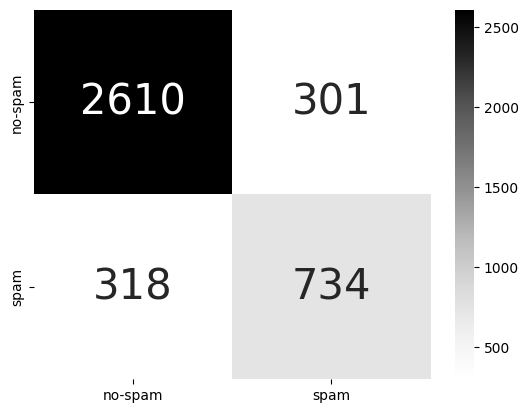

In [46]:
import os
import torch

model_name = "TextCNN_BasisCustLinear"
model_path = f"../input/vispamreviews-models/{model_name}/{model_name}_(1).pth"
model = ViSpam_Classifier(model_name, task=1).to(device)
model.load_state_dict(torch.load(model_path))
true_labels, predicts = test(model, test_dataloader, task=1)
test_cm = evaluate(true_labels, predicts)
plotting_confusion_matrix(test_cm, model_name, task=1)

In [47]:
import os
import pandas as pd

predict_df = pd.DataFrame({'comment': vispam_datasets['test']['comment'],
                           'category': vispam_datasets['test']['category'],
                           'description': vispam_datasets['test']['description'],
                           'label': true_labels, 'predict': predicts})
predict_df.to_csv(os.path.join(model_name, f'{model_name}_test_prediction_(1).csv'), index=False)
wrong_df = predict_df[predict_df.label != predict_df.predict]
sorted_df = wrong_df.sort_values(['label', 'predict'], ascending=[False, False])
sorted_df

comment  \
7     Giao h√†ng si√™u si√™u si√™u nhanh, ko ng·ªù lu√¥n.\r...   
8     Kakaa ba n·∫±m b√™n tr√°i th√¨ e b√© nh√©t qua b√™n tr...   
25    H√†ng ƒë·∫πp . giao r·∫•t ok , ·ªßng h·ªô ·∫° \r\nH√†ng ƒë·∫πp...   
29    giao h√†ng r·∫•t nhanh, g√≥i h√†ng c·∫©n th·∫≠n. C·∫£m ∆°n...   
34    Giao h√†ng nhanh. H√¨nh ·∫£nh vs video mang t√≠nh c...   
...                                                 ...   
3918  Giao h√†ng nhanh ƒë√£ nh·∫≠n ƒë∆∞·ª£c h√†ng. Kh√° v·ª´a √Ω. ...   
3925                         san pham tot.dung nhu hinh   
3940  Tr∆∞·ªõc gi·ªù to√†n ƒÉn v·ªã cay, nay mua th·ª≠ l·∫©u th·∫≠p...   
3945                                 H√†ng t·ªõi h l√† ngon   
3951  M√¨nh m·ªõi v·ª´a nh·∫≠n h√†ng, ƒë·ªëng g√≥i sp ƒë·∫πp, chƒÉcs...   

                   category  \
7               Ph∆∞∆°ng Ti·ªán   
8                Th·ªùi Trang   
25                     S√°ch   
29                  S·∫Øc ƒê·∫πp   
34       Nh√† C·ª≠a - ƒê·ªùi S·ªëng   
...                     ...   
3918               Th·ªÉ Thao   
3925                ƒêi·ªán T·ª≠   
3940                   Kh√°c   
3945  ƒêi·ªán Thoai - M√°y T√≠nh   
3951                ƒêi·ªán T·ª≠   

                                            description  label  predict  
7     TaÃÇÃÅm chaÃÜÃÅn che naÃÜÃÅng OÃÇ TOÃÇ Xe HoÃõi - PhuÃ£ ...      1        0  
8     Qu·∫ßn l√≥t nam thun l·∫°nh nh·∫≠t b·∫£n, qu·∫ßn s·ªãp ƒë√∫c ...      1        0  
25    Th·ªùi gian giao h√†ng d·ª± ki·∫øn cho s·∫£n ph·∫©m n√†y l...      1        0  
29    Mi·∫øng d√°n tr·∫Øng rƒÉng Crest 3D White t·∫©y tr·∫Øng ...      1        0  
34    5 l∆∞u √Ω tr∆∞·ªõc khi ƒë·∫∑t h√†ng: 1 - Mi·ªÖn ph√≠ v·∫≠n c...      1        0  
...                                                 ...    ...      ...  
3918  TH√îNG TIN S·∫¢N PH·∫®M - S·∫£n ph·∫©m: T·∫•t c·ªï ng·∫Øn - C...      0        1  
3925  AÃÅo veÃ£ÃÇ sinh maÃÅy laÃ£nh coÃÅ mieÃ£ÃÇng aÃÅo coÃÅ t...      0        1  
3940  üå∂Ô∏èGia V·ªã L·∫©u Haidilao (H·∫£i ƒê·∫ø Lao) Ch·∫Øc h·∫≥n ai...      0        1  
3945  MaÃÄn hiÃÄnh Liquid Retina iPad Air moÃõÃÅi soÃõÃâ h...      0        1  
3951  ThieÃÇÃÅt keÃÇÃÅ goÃ£n ƒëeÃ£p, voÃâ maÃÅy chaÃÇÃÅt lieÃ£ÃÇu...      0        1  

[619 rows x 5 columns]

Loaded pretrained embeddings, weights are not trainable.


  0%|          | 0/16 [00:00<?, ?it/s]

Accuracy: 0.8244
Precision: 0.6513
Recall: 0.6781
F1-score: 0.6596
Confusion matrix:
 [[2583   24  200  104]
 [  20   29    2    3]
 [ 109    1  189   10]
 [ 182    8   33  466]]
              precision    recall  f1-score   support

           0     0.8925    0.8873    0.8899      2911
           1     0.4677    0.5370    0.5000        54
           2     0.4458    0.6117    0.5157       309
           3     0.7993    0.6763    0.7327       689

    accuracy                         0.8244      3963
   macro avg     0.6513    0.6781    0.6596      3963
weighted avg     0.8357    0.8244    0.8281      3963



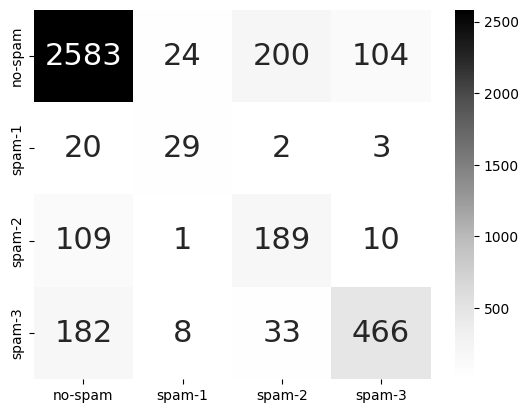

In [48]:
import os
import torch

model_name = "TextCNN_BasisCustLinear"
model_path = f"../input/vispamreviews-models/{model_name}/{model_name}_(2).pth"
model = ViSpam_Classifier(model_name, task=2).to(device)
model.load_state_dict(torch.load(model_path))
true_labels, predicts = test(model, test_dataloader, task=2)
test_cm = evaluate(true_labels, predicts)
plotting_confusion_matrix(test_cm, model_name, task=2)

In [49]:
import pandas as pd

predict_df = pd.DataFrame({'comment': vispam_datasets['test']['comment'],
                           'category': vispam_datasets['test']['category'],
                           'description': vispam_datasets['test']['description'],
                           'spam_label': true_labels, 'predict': predicts})
predict_df.to_csv(os.path.join(model_name, f'{model_name}_test_prediction_(2).csv'), index=False)
wrong_df = predict_df[predict_df.spam_label != predict_df.predict]
sorted_df = wrong_df.sort_values(['spam_label', 'predict'], ascending=[False, False])
sorted_df

comment            category  \
285   Giao ch·∫≠m nhg nhanh nh∆∞ c∆°n gi√≥, ship uy t√≠n n...                Kh√°c   
536   Giao h√†ng h∆°i l√¢u, ƒë√≥ng g√≥i ƒë∆∞·ª£c, n√≥i chung c≈©...  Nh√† C·ª≠a - ƒê·ªùi S·ªëng   
586   shop giao h√†ng nhanh, chu ƒë√°o, c·∫©n th·∫≠n r·∫•t h√†...             ƒê·ªì Ch∆°i   
628   Giao h√†ng nhanh ch√≥ng,bbdbfbfjfjhfbfhfhhfjfhfh...  Nh√† C·ª≠a - ƒê·ªùi S·ªëng   
700   CaÃâm oÃõn b ƒëaÃÉ tin tuÃõoÃõÃâng vaÃÄ uÃâng hoÃ£ÃÇ kiÃÅn...                Kh√°c   
...                                                 ...                 ...   
2415  ƒê√≥ng g√≥i s·∫£n ph·∫©m tuy·ªát v·ªùi!!!\r\nH√†ng k√≠ch th...          Th·ªùi Trang   
2599                     Mua ƒë∆∞·ª£c gi·∫£m gi√° s·∫£n ph·∫©m t·ªët                Kh√°c   
2732  Ch·∫•t l∆∞·ª£ng s·∫£n ph·∫©m tuy·ªát v·ªùi. ƒê√≥ng g√≥i s·∫£n ph...          Th·ªùi Trang   
3829  Giao h√†ng nhanh balo ƒë·ªânh lu√¥n v·ªõi gi√° th·∫ø n√†y...          Th·ªùi Trang   
3879  Ch·∫•t l∆∞·ª£ng s·∫£n ph·∫©m tuy·ªát v·ªùi, giao h√†ng nhanh...                S√°ch   

                                            description  spam_label  predict  
285   H∆Ø·ªöNG D·∫™N MUA TH·∫∫ Viettel 100k ,QU√ù KH√ÅCH VUI ...           3        2  
536   S·∫£n ph·∫©m khƒÉn gi·∫•y ∆∞·ªõt ƒë∆∞·ª£c s·∫£n xu·∫•t t·ª´ nguy√™n...           3        2  
586   M√°y T·∫°o Ti·∫øng ·ªín Tr·∫Øng Gi√∫p b√© ng·ªß ngon, s√¢u g...           3        2  
628   Cam k·∫øt: - H√†ng chu·∫©n c√¥ng ty, d√†y ƒë·∫πp - Kh√¥ng...           3        2  
700   [E-voucher] M√£ mua h√†ng Shopee (tr∆∞ÃÄ NaÃ£p TheÃâ...           3        2  
...                                                 ...         ...      ...  
2415  ƒê·∫∂C ƒêI·ªÇM N·ªîI B·∫¨T: ‚Äì ƒê∆∞·ª£c l√†m t·ª´ ch·∫•t li·ªáu nh·ª±a...           0        1  
2599  CaÃÄ PheÃÇ Rang Xay Moka Highlands Coffee (200g)...           0        1  
2732  T√∫i Zip ƒê·ª±ng ƒê·ªì Trong Su·ªët Nhi·ªÅu Size Ho·∫° Ti·∫øt...           0        1  
3829  Balo Laptop nam n·ªØ Th·ªùi Trang ch·ªëng tr·ªôm, ch·ªën...           0        1  
3879   Th·ªùi gian giao h√†ng d·ª± ki·∫øn cho s·∫£n ph·∫©m n√†y ...           0        1  

[696 rows x 5 columns]

In [50]:
import numpy as np
import torch
import torch.nn.functional as F

class_names = ['no-spam', 'spam']
spam_class_names = ['no-spam', 'spam-1', 'spam-2', 'spam-3']

def encode_text(text, word2idx, max_len=100):
    tokenized_text = word_tokenize(text)
    if len(tokenized_text) > max_len:
        tokenized_text = tokenized_text[:max_len]
    tokenized_text += ['<pad>'] * (max_len - len(tokenized_text))
    input_id = [word2idx.get(token, word2idx['<unk>']) for token in tokenized_text]
    return np.array(input_id)

def inference(model, text, category, word2idx, category2idx, task=1): 
    model.eval()
    
    input_ids = encode_text(text, word2idx, max_len=100)
    input_ids = torch.tensor(input_ids).unsqueeze(0).to(device)
    category_id = torch.tensor(category2idx[category]).unsqueeze(0).to(device)
    with torch.no_grad():
        outputs = model(input_ids, category_id)
    predict_label = torch.argmax(outputs, dim=1)[0]
    probability = F.softmax(outputs, dim=1)[0][predict_label]
    
    print(f'Comment: {text}')
    print(f'Category: {category}')
    print(f'Predict: {class_names[predict_label] if task == 1 else spam_class_names[predict_label]}')
    print(f'Probability: {round(probability.cpu().item(), 4)}')

In [51]:
category2idx = {
    'ƒêi·ªán Thoai - M√°y T√≠nh': 0,
    'Kh√°c': 1,
    'M√°y ·∫¢nh': 2,
    'Nh√† C·ª≠a - ƒê·ªùi S·ªëng': 3,
    'ƒêi·ªán T·ª≠': 4,
    'Th·ªùi Trang': 5,
    'S·∫Øc ƒê·∫πp': 6,
    'S√°ch': 7,
    'Ph∆∞∆°ng Ti·ªán': 8,
    'Gi√†y D√©p': 9, 
    'Th·ªÉ Thao': 10,
    'ƒê·ªì Ch∆°i': 11,
}

task = 2
model_name = "TextCNN_BasisCustLinear"
model = ViSpam_Classifier(model_name, task=2).to(device)
model_path = f"../input/vispamreviews-models/{model_name}/{model_name}_({task}).pth"
model.load_state_dict(torch.load(model_path))

comment = 'ƒëi·ªán tho·∫°i nokia th√¨ kh√¥ng ph·∫£i b√†n r·ªìi'
category = 'ƒêi·ªán Thoai - M√°y T√≠nh'
inference(model, comment, category, word2idx, category2idx, task)

Loaded pretrained embeddings, weights are not trainable.
Comment: ƒëi·ªán tho·∫°i nokia th√¨ kh√¥ng ph·∫£i b√†n r·ªìi
Category: ƒêi·ªán Thoai - M√°y T√≠nh
Predict: no-spam
Probability: 0.6923


# PhoBERT + SPhoBert

In [52]:
import sys

sys.path.append("../input/sentence-transformers")

In [53]:
from torch import nn
from transformers import AutoModel, BertModel

class ViSpam_Classifier(nn.Module):
    def __init__(self, model_name, task, freeze_bert=False, drop=0.3):
        super(ViSpam_Classifier, self).__init__()
        
        assert model_name in ['PhoBERT_SPhoBert', 'BERT4News_SBert4News', 'ViBERT_Description']
        
        self.model_name = model_name
        self.task = task
        self.num_classes = 2 if task == 1 else 4
        self.desc_size = 768
        
        if 'PhoBERT' in model_name:
            self.bert = AutoModel.from_pretrained('vinai/phobert-base')
        else:
            self.bert = BertModel.from_pretrained('NlpHUST/vibert4news-base-cased')
            
        if freeze_bert:
            for param in self.bert.parameters():
                param.requires_grad = False
        
        self.drop = nn.Dropout(drop)
        self.fc = nn.Linear(self.bert.config.hidden_size + self.desc_size, self.num_classes)
        # nn.init.normal_(self.fc.weight, std=0.02)
        # nn.init.normal_(self.fc.bias, 0)
        
    def forward(self, input_ids, attention_mask, description):
        last_hidden_state, output = self.bert(input_ids=input_ids, attention_mask=attention_mask, return_dict=False)
        conc = torch.cat((output, description), 1)
        x = self.drop(conc)
        x = self.fc(x)
        return x
    

def test(model, dataloader, task):
    model.eval()
    predicts = []
    predict_probs = []
    true_labels = []
    
    label_column = 'label' if task == 1 else 'spam_label'

    for data in tqdm(dataloader):
        input_ids = data['input_ids'].to(device)
        attention_mask = data['attention_mask'].to(device)
        description = data[f'encoded_description_{task}'].to(device)
        labels = data[label_column].to(device)
        
        with torch.no_grad():
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, description=description)
            
        pred = torch.max(outputs, dim=1)[1]
        predicts.extend(pred.cpu().data.numpy())
        predict_probs.extend(outputs.cpu().data.numpy())
        true_labels.extend(labels.cpu().data.numpy())
        
    return true_labels, predicts

In [54]:
from sentence_transformers import SentenceTransformer

model_dir = '../input/vispamreviews-models/PhoBERT_SPhoBert/SPhoBert/'
model_name = "vinai-phobert-base"
sentence_model_1 = SentenceTransformer(model_dir + f'training_nli_{model_name}-task-1-tokenized', device=device)
sentence_model_2 = SentenceTransformer(model_dir + f'training_nli_{model_name}-task-2-tokenized', device=device)

def encode_description(example):
    embeddings_1 = sentence_model_1.encode(example['clean_description'], show_progress_bar=False)
    embeddings_2 = sentence_model_2.encode(example['clean_description'], show_progress_bar=False)
    return {'encoded_description_1': embeddings_1, 'encoded_description_2': embeddings_2}

encoded_datasets = vispam_datasets.map(encode_description, batched=True)

  0%|          | 0/15 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/4 [00:00<?, ?ba/s]

In [55]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base")

def encode_comment(examples):
    return tokenizer(examples["clean_tokenized_comment"], padding="max_length", max_length=100, truncation=True, add_special_tokens=True)

encoded_datasets = encoded_datasets.map(encode_comment, batched=True)
encoded_datasets = encoded_datasets.remove_columns(vispam_datasets['train'].column_names[:-4])
encoded_datasets.set_format("torch")

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


  0%|          | 0/15 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/4 [00:00<?, ?ba/s]

In [56]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(encoded_datasets['train'], shuffle=True, batch_size=256)
val_dataloader = DataLoader(encoded_datasets['dev'], batch_size=256)
test_dataloader = DataLoader(encoded_datasets['test'], batch_size=256)

Some weights of the model checkpoint at vinai/phobert-base were not used when initializing RobertaModel: ['lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.bias', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/16 [00:00<?, ?it/s]

Accuracy: 0.9011
Precision: 0.8751
Recall: 0.8695
F1-score: 0.8722
Confusion matrix:
 [[2727  184]
 [ 208  844]]
              precision    recall  f1-score   support

           0     0.9291    0.9368    0.9329      2911
           1     0.8210    0.8023    0.8115      1052

    accuracy                         0.9011      3963
   macro avg     0.8751    0.8695    0.8722      3963
weighted avg     0.9004    0.9011    0.9007      3963



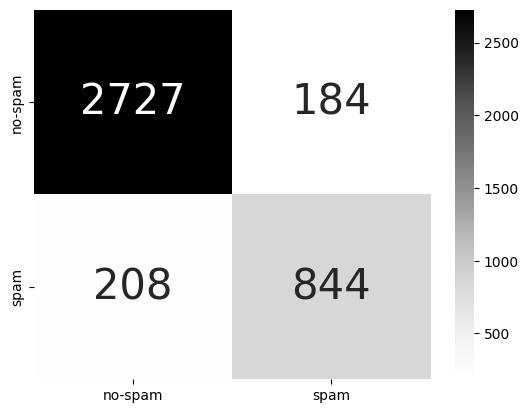

In [57]:
import os
import torch

model_name = "PhoBERT_SPhoBert"
model_path = f"../input/vispamreviews-models/{model_name}/{model_name}_(1).pth"
model = ViSpam_Classifier(model_name, task=1).to(device)
model.load_state_dict(torch.load(model_path))
true_labels, predicts = test(model, test_dataloader, task=1)
test_cm = evaluate(true_labels, predicts)
plotting_confusion_matrix(test_cm, model_name, task=1)

In [58]:
import os
import pandas as pd

predict_df = pd.DataFrame({'comment': vispam_datasets['test']['comment'],
                           'category': vispam_datasets['test']['category'],
                           'description': vispam_datasets['test']['description'],
                           'label': true_labels, 'predict': predicts})
predict_df.to_csv(os.path.join(model_name, f'{model_name}_test_prediction_(1).csv'), index=False)
wrong_df = predict_df[predict_df.label != predict_df.predict]
sorted_df = wrong_df.sort_values(['label', 'predict'], ascending=[False, False])
sorted_df

comment  \
25    H√†ng ƒë·∫πp . giao r·∫•t ok , ·ªßng h·ªô ·∫° \r\nH√†ng ƒë·∫πp...   
38    Mua bnh c√°i t√∫i ƒë·ª±ng b√†i c≈©ng k bao h l√† ƒë·ªß ·∫•y...   
44    Kh√¥ng ch·ª•p ·∫£nh ƒë∆∞·ª£c s·∫£n ph·∫©m n√™n m√¨nh l·∫•y t·∫°m ...   
53    h√†ng OK r·ªìi em v·∫´n ƒëang ti·∫øp t·ª•c v√†o vai m·ªôt c...   
60    Giao nhanh c·ªßa Tiki Now. H√†ng ok, ƒë·ªÉ l·∫Øp v√†o x...   
...                                                 ...   
3840  D√¢y y h√¨nh\r\nƒê√≥ng g√≥i c·∫¢n th·∫≠n\r\nS·∫Ω ·ªßng h·ªô s...   
3896                                T·∫°m th·ªùi l√† d√πng ·ªïn   
3913  Si√™u tooooo\r\nGiao h√†ng si√™u nhanh\r\nH√†ng s·ª≠...   
3938  Giao h√†ng nhanh, vi√™n n√©n xinh. Giao h√†ng nhan...   
3940  Tr∆∞·ªõc gi·ªù to√†n ƒÉn v·ªã cay, nay mua th·ª≠ l·∫©u th·∫≠p...   

                   category  \
25                     S√°ch   
38       Nh√† C·ª≠a - ƒê·ªùi S·ªëng   
44                  M√°y ·∫¢nh   
53                     Kh√°c   
60    ƒêi·ªán Thoai - M√°y T√≠nh   
...                     ...   
3840               Th·ªÉ Thao   
3896                ƒêi·ªán T·ª≠   
3913                ƒêi·ªán T·ª≠   
3938     Nh√† C·ª≠a - ƒê·ªùi S·ªëng   
3940                   Kh√°c   

                                            description  label  predict  
25    Th·ªùi gian giao h√†ng d·ª± ki·∫øn cho s·∫£n ph·∫©m n√†y l...      1        0  
38    T√∫i Nhung ƒê∆∞ng Tarot Ti·ªÅn Cao C·∫•p T√∫i v·∫£i nhun...      1        0  
44    ƒê·∫∑c t√≠nh ∆∞u Vi·ªát c·ªßa Camera Yoosee Ti·∫øng Vi·ªát ...      1        0  
53    DaÃÇÃÄu AÃÜn ThuÃõoÃõÃ£ng HaÃ£ng NhaÃÉn HieÃ£ÃÇu Neptune...      1        0  
60    ToÃÇÃÅc ƒëoÃ£ÃÇ cuÃõÃ£c cao RAM Laptop Samsung 8GB DD...      1        0  
...                                                 ...    ...      ...  
3840  üëâSPORT 247 cam k·∫øt gi√° b√°n r·∫ª nh·∫•t shopee ·ªü ƒë√¢...      0        1  
3896  ThieÃÇÃÅt keÃÇÃÅ thaÃÇn thieÃ£ÃÇn Logitech B100 suÃõÃâ ...      0        1  
3913  GIAO HAÃÄNG VAÃÄ LAÃÜÃÅP ƒêAÃ£ÃÜT CUÃÄNG LUÃÅCGiaÃÅ saÃân...      0        1  
3938  M√¥ t·∫£ s·∫£n ph·∫©m: - M√πa h√®, m√πa du l·ªãch, m√πa d√£ ...      0        1  
3940  üå∂Ô∏èGia V·ªã L·∫©u Haidilao (H·∫£i ƒê·∫ø Lao) Ch·∫Øc h·∫≥n ai...      0        1  

[392 rows x 5 columns]

Some weights of the model checkpoint at vinai/phobert-base were not used when initializing RobertaModel: ['lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.bias', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/16 [00:00<?, ?it/s]

Accuracy: 0.8806
Precision: 0.7492
Recall: 0.7241
F1-score: 0.7349
Confusion matrix:
 [[2710   11  139   51]
 [  17   30    1    6]
 [ 120    1  180    8]
 [  92    4   23  570]]
              precision    recall  f1-score   support

           0     0.9221    0.9310    0.9265      2911
           1     0.6522    0.5556    0.6000        54
           2     0.5248    0.5825    0.5521       309
           3     0.8976    0.8273    0.8610       689

    accuracy                         0.8806      3963
   macro avg     0.7492    0.7241    0.7349      3963
weighted avg     0.8832    0.8806    0.8815      3963



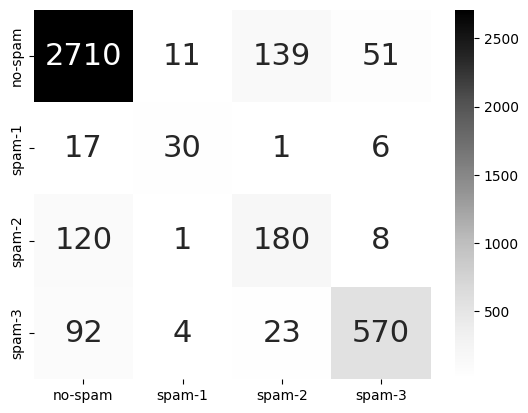

In [59]:
import os
import torch

model_name = "PhoBERT_SPhoBert"
model_path = f"../input/vispamreviews-models/{model_name}/{model_name}_(2).pth"
model = ViSpam_Classifier(model_name, task=2).to(device)
model.load_state_dict(torch.load(model_path))
true_labels, predicts = test(model, test_dataloader, task=2)
test_cm = evaluate(true_labels, predicts)
plotting_confusion_matrix(test_cm, model_name, task=2)

In [60]:
import pandas as pd

predict_df = pd.DataFrame({'comment': vispam_datasets['test']['comment'],
                           'category': vispam_datasets['test']['category'],
                           'description': vispam_datasets['test']['description'],
                           'spam_label': true_labels, 'predict': predicts})
predict_df.to_csv(os.path.join(model_name, f'{model_name}_test_prediction_(2).csv'), index=False)
wrong_df = predict_df[predict_df.spam_label != predict_df.predict]
sorted_df = wrong_df.sort_values(['spam_label', 'predict'], ascending=[False, False])
sorted_df

comment  \
59    H√†ng ·∫° g·ªüi b√†i v√†o v√†o ƒë√¢y ·∫° g·ª≠i g·ª≠i v√†o t√∫i n...   
766                                           giao h√†ng   
805                           Shop k·∫øt n·ªëi sao v·∫≠y shop   
887   Kh√°ch S·ªâ ƒë·∫∑t em l√¥ h√†ng l·ªõn m√† gi·ªù ch·ªó kh√°ch b...   
1005  ƒê·∫∑t 8 c·ª≠a shop giao c√≥ 5 c·ª≠a nt shop k ph·∫£n h·ªì...   
...                                                 ...   
1827  Ch·∫•t l∆∞·ª£ng s·∫£n ph·∫©m tuy·ªát v·ªùi, giao h√†ng nhanh...   
2732  Ch·∫•t l∆∞·ª£ng s·∫£n ph·∫©m tuy·ªát v·ªùi. ƒê√≥ng g√≥i s·∫£n ph...   
2826  Ch·∫•t l∆∞·ª£ng s·∫£n ph·∫©m tuy·ªát v·ªùi , giao h√†ng nhan...   
2909                  Ch·∫•t l∆∞·ª£ng s·∫£n ph·∫©m tuy·ªát v·ªùi, m√°   
3879  Ch·∫•t l∆∞·ª£ng s·∫£n ph·∫©m tuy·ªát v·ªùi, giao h√†ng nhanh...   

                   category  \
59               Th·ªùi Trang   
766                    Kh√°c   
805                 M√°y ·∫¢nh   
887      Nh√† C·ª≠a - ƒê·ªùi S·ªëng   
1005               Th·ªÉ Thao   
...                     ...   
1827  ƒêi·ªán Thoai - M√°y T√≠nh   
2732             Th·ªùi Trang   
2826            Ph∆∞∆°ng Ti·ªán   
2909                ƒêi·ªán T·ª≠   
3879                   S√°ch   

                                            description  spam_label  predict  
59    Th·ªùi gian giao h√†ng d·ª± ki·∫øn cho s·∫£n ph·∫©m n√†y l...           3        2  
766   LUÃõU YÃÅ: Bao BiÃÄ SaÃân phaÃÇÃâm coÃÅ theÃÇÃâ thay ƒëo...           3        2  
805   * SaÃân phaÃÇÃâm coÃÅ 3 thuoÃ£ÃÇc tiÃÅnh luÃõÃ£a choÃ£n,...           3        2  
887    Th·ªùi gian giao h√†ng d·ª± ki·∫øn cho s·∫£n ph·∫©m n√†y ...           3        2  
1005  Gi·ªõi thi·ªáu s·∫£n ph·∫©m L∆∞·ªõi b√°t qu√°i ƒë√°nh b·∫Øt c√° ...           3        2  
...                                                 ...         ...      ...  
1827  L√≥t chu·ªôt c·ª° l·ªõn 80x30cm chuy√™n game ch·ªëng tr∆°...           0        1  
2732  T√∫i Zip ƒê·ª±ng ƒê·ªì Trong Su·ªët Nhi·ªÅu Size Ho·∫° Ti·∫øt...           0        1  
2826  Ch·∫•t Li·ªáu : Titan ƒê·∫∑c T√≠nh : L√† H·ª£p Kim C·ª©ng H...           0        1  
2909  ThieÃÇÃÅt keÃÇÃÅ hieÃ£ÃÇn ƒëaÃ£i, tinh teÃÇÃÅ MaÃÅy laÃ£nh...           0        1  
3879   Th·ªùi gian giao h√†ng d·ª± ki·∫øn cho s·∫£n ph·∫©m n√†y ...           0        1  

[473 rows x 5 columns]

In [61]:
import torch
from transformers import AutoTokenizer
from sentence_transformers import SentenceTransformer

def inference(model, comment, description, tokenizer, task=1):
    model.eval()
    
    # Comment
    tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base")
    data = tokenizer(comment, padding="max_length", max_length=100, truncation=True, add_special_tokens=True)
    input_ids = torch.tensor(data['input_ids']).unsqueeze(0).to(device)
    attention_mask = torch.tensor(data['attention_mask']).unsqueeze(0).to(device)
    
    # Description
    model_dir = '../input/vispamreviews-models/PhoBERT_SPhoBert/SPhoBert/'
    model_name = "vinai-phobert-base"
    sentence_model = SentenceTransformer(model_dir + f'training_nli_{model_name}-task-{task}-tokenized', device=device)
    encoded_description = sentence_model.encode(description, show_progress_bar=False)
    encoded_description = torch.tensor(encoded_description).unsqueeze(0).to(device)
    
    with torch.no_grad():
        outputs = model(input_ids, attention_mask, encoded_description)
    predict_label = torch.argmax(outputs, dim=1)[0]
    probability = F.softmax(outputs, dim=1)[0][predict_label]
    
    print(f'Comment: {comment}')
    print(f'Description: {description}')
    print(f'Predict: {class_names[predict_label] if task == 1 else spam_class_names[predict_label]}')
    print(f'Probability: {round(probability.cpu().item(), 4)}')

In [62]:
task = 2
model_name = "PhoBERT_SPhoBert"
model = ViSpam_Classifier(model_name, task).to(device)
model_path = f"../input/vispamreviews-models/{model_name}/{model_name}_({task}).pth"
model.load_state_dict(torch.load(model_path))

comment = 'n√≥i chung l√† h√†ng m·ªõi nh·∫≠n th√¥i, m√¨nh ch∆∞a bi·∫øt d√πng c√≥ t·ªët kh√¥ng n·ªØa, l·∫ßn sau s·∫Ω ƒë√°nh gi√°'
description = "gi√†y ƒë·∫πp ph√π h·ª£p v·ªõi m·ªçi ng∆∞·ªùi"
inference(model, comment, description, tokenizer, task)

Some weights of the model checkpoint at vinai/phobert-base were not used when initializing RobertaModel: ['lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.bias', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Comment: n√≥i chung l√† h√†ng m·ªõi nh·∫≠n th√¥i, m√¨nh ch∆∞a bi·∫øt d√πng c√≥ t·ªët kh√¥ng n·ªØa, l·∫ßn sau s·∫Ω ƒë√°nh gi√°
Description: gi√†y ƒë·∫πp ph√π h·ª£p v·ªõi m·ªçi ng∆∞·ªùi
Predict: no-spam
Probability: 0.9597


# BiLSTM - BasisCustLinear + SBert4News

In [63]:
class TextCNN(nn.Module):
    def __init__(self, embedding_dim, kernel_sizes=[2, 3, 5], num_filters=32):
        super(TextCNN, self).__init__()
        
        self.conv = nn.ModuleList([nn.Conv1d(in_channels=embedding_dim, out_channels=num_filters, kernel_size=k, stride=1) for k in kernel_sizes])
        
    def forward(self, h_embedding, description):
        x = h_embedding.permute(0, 2, 1)
        x = [F.relu(conv(x)) for conv in self.conv]
        x = [F.max_pool1d(c, kernel_size=c.shape[2]).squeeze(dim=2) for c in x]
        x = torch.cat(x, dim=1)
        desc_conc = torch.cat((x, description), dim=1)
        return desc_conc
        
        
class BiLSTM(nn.Module):
    def __init__(self, embedding_dim, hidden_size):
        super(BiLSTM, self).__init__()
        
        self.lstm = nn.LSTM(embedding_dim, hidden_size, bidirectional=True, batch_first=True)
    
    def forward(self, h_embedding, description):
        h_lstm, _ = self.lstm(h_embedding)
        avg_pool = torch.mean(h_lstm, 1)
        max_pool, _ = torch.max(h_lstm, 1)
        conc = torch.cat((avg_pool, max_pool), dim=1)
        desc_conc = torch.cat((conc, description), dim=1)
        return desc_conc
        
        
class BiGRU(nn.Module):
    def __init__(self, embedding_dim, hidden_size):
        super(BiGRU, self).__init__()
        
        self.gru = nn.GRU(embedding_dim, hidden_size, bidirectional=True, batch_first=True)
    
    def forward(self, h_embedding, description):
        h_gru, _ = self.gru(h_embedding)
        avg_pool = torch.mean(h_gru, 1)
        max_pool, _ = torch.max(h_gru, 1)
        conc = torch.cat((avg_pool, max_pool), dim=1)
        desc_conc = torch.cat((conc, description), dim=1)
        return desc_conc

In [64]:
import torch
from torch import nn

class ViSpam_Classifier(nn.Module):
    def __init__(self, model_name, task, kernel_sizes=[2, 3, 5], num_filters=32, hidden_size=64, drop=0.5, spatial_dropout=True, mode='static'):
        super(ViSpam_Classifier, self).__init__()
        
        self.model_name = model_name
        name, model_type, _ = model_name.split('_')
        
        assert name in ['TextCNN', 'BiLSTM', 'BiGRU']
        assert model_type in ['CustBias', 'CustLinear', 'CustWordEmbedding', 'BasisCustBias', 'BasisCustLinear', 'BasisCustWordEmbedding']
        
        self.task = task
        self.num_classes = 2 if task == 1 else 4
        self.vocab_size, self.embedding_dim = embeddings.shape
        self.kernel_sizes = kernel_sizes
        self.num_filters = num_filters
        self.hidden_size = hidden_size
        self.drop = drop
        self.spatial_dropout = spatial_dropout
        self.mode = mode
        
        self.meta_dim = 64
        self.key_query_size = 64
        self.num_bases = 4
        
        self.meta_param_manager = MetaParamManager()
        self.meta_units = [('category_id', num_categories)]\
        
        self.desc_size = 768
        
        # Word embedding
        if model_type == 'CustWordEmbedding':
            self.embedding = CustWordEmbedding(
                vocab_size=self.vocab_size,
                embedding_dim=self.embedding_dim,
                meta_units=self.meta_units,
                meta_param_manager=self.meta_param_manager
            )
        elif model_type == 'BasisCustWordEmbedding':
            self.embedding = BasisCustWordEmbedding(
                vocab_size=self.vocab_size,
                embedding_dim=self.embedding_dim,
                meta_units=self.meta_units,
                meta_dim=self.meta_dim,
                key_query_size=self.key_query_size,
                num_bases=self.num_bases,
                meta_param_manager=self.meta_param_manager
            )
        else:
            self.embedding = BasicWordEmbedding(vocab_size=self.vocab_size, embedding_dim=self.embedding_dim)
            
        self.embedding.load_embeddings(mode)
        
        # Spatial dropout
        if spatial_dropout:
            self.spatial_dropout1d = nn.Dropout2d(drop)
        else:
            self.dropout = nn.Dropout(drop)
        
        # Model
        if name == 'TextCNN':
            self.network = TextCNN(self.embedding_dim, kernel_sizes, num_filters)
            self.state_size = len(kernel_sizes)*num_filters
        elif name == 'BiLSTM':
            self.network = BiLSTM(self.embedding_dim, hidden_size)
            self.state_size = hidden_size*4
        else:
            self.network = BiGRU(self.embedding_dim, hidden_size)
            self.state_size = hidden_size*4
            
        self.state_size += self.desc_size
        
        # Linear
        if model_type == 'CustLinear':
            self.W = CustLinear(
                meta_units=self.meta_units,
                state_size=self.state_size,
                num_classes=self.num_classes,
                meta_param_manager=self.meta_param_manager
            )
        elif model_type == 'BasisCustLinear':
            self.W = BasisCustLinear(
                meta_units=self.meta_units,
                meta_dim=self.meta_dim,
                key_query_size=self.key_query_size,
                state_size=self.state_size,
                num_bases=self.num_bases,
                num_classes=self.num_classes,
                meta_param_manager=self.meta_param_manager
            )
        else:
            self.W = BasicLinear(state_size=self.state_size, num_classes=self.num_classes)
            
        # Bias
        if model_type == 'CustBias':
            self.bias = CustBias(
                meta_units=self.meta_units,
                state_size=self.state_size,
                num_classes=self.num_classes,
                meta_param_manager=self.meta_param_manager
            )
        elif model_type == 'BasisCustBias':
            self.bias = BasisCustBias(
                meta_units=self.meta_units,
                meta_dim=self.meta_dim,
                state_size=self.state_size,
                key_query_size=self.key_query_size,
                num_bases=self.num_bases,
                num_classes=self.num_classes,
                meta_param_manager=self.meta_param_manager
            )
        else:
            self.bias = BasicBias(self.num_classes)
            
    def forward(self, input_ids, category_id, description):
        batch_size, sequence_length = input_ids.shape
        
        if 'CustWordEmbedding' in self.model_name:
            h_embedding = self.embedding(input_ids, category_id)
        else:
            h_embedding = self.embedding(input_ids)
        
        if self.spatial_dropout:
            h_embedding = h_embedding.permute(0, 2, 1)
            h_embedding = self.spatial_dropout1d(h_embedding)
            h_embedding = h_embedding.permute(0, 2, 1)
        else:
            h_embedding = self.dropout(h_embedding)
        
        output_net = self.network(h_embedding, description)
        
        if 'CustLinear' in self.model_name:
            x = self.W(output_net, category_id)
        else:
            x = self.W(output_net)
        
        if 'CustBias' in self.model_name:
            x += self.bias(category_id)
        else:
            x += self.bias()
        
        return x
    

def test(model, dataloader, task):
    model.eval()
    predicts = []
    predict_probs = []
    true_labels = []
    
    label_column = 'label' if task == 1 else 'spam_label'
    
    for data in tqdm(dataloader):
        input_ids = data['input_id'].to(device)
        category_id = data['category_id'].to(device)
        description = data[f'encoded_description_{task}'].to(device)
        labels = data[label_column].to(device)

        with torch.no_grad():
            outputs = model(input_ids, category_id, description)
  
        pred = torch.max(outputs, dim=1)[1]
        predicts.extend(pred.cpu().data.numpy())
        predict_probs.extend(outputs.cpu().data.numpy())
        true_labels.extend(labels.cpu().data.numpy())
        
    return true_labels, predicts

In [65]:
category2idx = {
    'Th·ªùi Trang': 0,
    'S√°ch': 1,
    'ƒêi·ªán Thoai - M√°y T√≠nh': 2,
    'ƒê·ªì Ch∆°i': 3,
    'S·∫Øc ƒê·∫πp': 4,
    'Th·ªÉ Thao': 5,
    'Nh√† C·ª≠a - ƒê·ªùi S·ªëng': 6,
    'Kh√°c': 7,
    'Ph∆∞∆°ng Ti·ªán': 8, 
    'M√°y ·∫¢nh': 9,
    'Gi√†y D√©p': 10,
    'ƒêi·ªán T·ª≠': 11,
} 
num_categories = len(category2idx)
print("Number of categories:", num_categories)

Number of categories: 12


In [66]:
from sentence_transformers import SentenceTransformer

model_dir = "../input/vispamreviews-models/BiLSTM_BasisCustLinear_SBert4News/SBert4News/"
model_name = "NlpHUST-vibert4news-base-cased"

sentence_model_1 = SentenceTransformer(model_dir + f"training_nli_{model_name}-task-1", device=device)
sentence_model_2 = SentenceTransformer(model_dir + f"training_nli_{model_name}-task-2", device=device)

def encode_description(example):
    embeddings_1 = sentence_model_1.encode(example['clean_description'], show_progress_bar=False)
    embeddings_2 = sentence_model_2.encode(example['clean_description'], show_progress_bar=False)
    return {'encoded_description_1': embeddings_1, 'encoded_description_2': embeddings_2}

vispam_datasets = vispam_datasets.map(encode_description, batched=True)

  0%|          | 0/15 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/4 [00:00<?, ?ba/s]

In [67]:
def encode_mapping(examples):
    tokenized_texts = [word_tokenize(sent) for sent in examples['clean_comment']]
    input_ids = encoding(tokenized_texts, word2idx, max_len=100)
    category_ids = [category2idx[category] for category in examples['category']]
    
    return {'input_id': input_ids, "category_id": category_ids}


encoded_datasets = vispam_datasets.map(encode_mapping, batched=True)
encoded_datasets = encoded_datasets.remove_columns(vispam_datasets['train'].column_names[:-4])
encoded_datasets.set_format("torch")

  0%|          | 0/15 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/4 [00:00<?, ?ba/s]

In [68]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(encoded_datasets['train'], shuffle=True, batch_size=256)
val_dataloader = DataLoader(encoded_datasets['dev'], batch_size=256)
test_dataloader = DataLoader(encoded_datasets['test'], batch_size=256)

Loaded pretrained embeddings, weights are not trainable.


  0%|          | 0/16 [00:00<?, ?it/s]

Accuracy: 0.8451
Precision: 0.8001
Recall: 0.8089
F1-score: 0.8043
Confusion matrix:
 [[2579  332]
 [ 282  770]]
              precision    recall  f1-score   support

           0     0.9014    0.8859    0.8936      2911
           1     0.6987    0.7319    0.7149      1052

    accuracy                         0.8451      3963
   macro avg     0.8001    0.8089    0.8043      3963
weighted avg     0.8476    0.8451    0.8462      3963



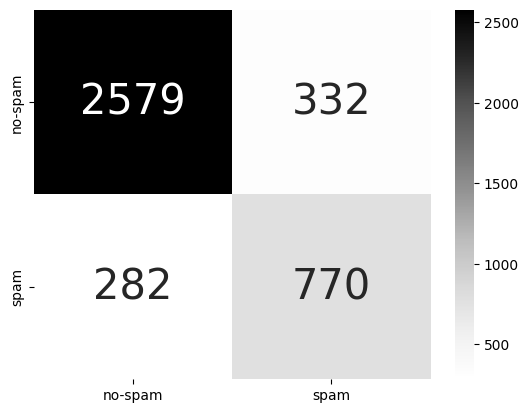

In [69]:
import os
import torch

model_name = "BiLSTM_BasisCustLinear_SBert4News"
model_path = f"../input/vispamreviews-models/{model_name}/{model_name}_(1).pth"
model = ViSpam_Classifier(model_name, task=1).to(device)
model.load_state_dict(torch.load(model_path))
true_labels, predicts = test(model, test_dataloader, task=1)
test_cm = evaluate(true_labels, predicts)
plotting_confusion_matrix(test_cm, model_name, task=1)

In [70]:
import os
import pandas as pd

predict_df = pd.DataFrame({'comment': vispam_datasets['test']['comment'],
                           'category': vispam_datasets['test']['category'],
                           'description': vispam_datasets['test']['description'],
                           'label': true_labels, 'predict': predicts})
predict_df.to_csv(os.path.join(model_name, f'{model_name}_test_prediction_(1).csv'), index=False)
wrong_df = predict_df[predict_df.label != predict_df.predict]
sorted_df = wrong_df.sort_values(['label', 'predict'], ascending=[False, False])
sorted_df

comment  \
7     Giao h√†ng si√™u si√™u si√™u nhanh, ko ng·ªù lu√¥n.\r...   
8     Kakaa ba n·∫±m b√™n tr√°i th√¨ e b√© nh√©t qua b√™n tr...   
25    H√†ng ƒë·∫πp . giao r·∫•t ok , ·ªßng h·ªô ·∫° \r\nH√†ng ƒë·∫πp...   
34    Giao h√†ng nhanh. H√¨nh ·∫£nh vs video mang t√≠nh c...   
38    Mua bnh c√°i t√∫i ƒë·ª±ng b√†i c≈©ng k bao h l√† ƒë·ªß ·∫•y...   
...                                                 ...   
3918  Giao h√†ng nhanh ƒë√£ nh·∫≠n ƒë∆∞·ª£c h√†ng. Kh√° v·ª´a √Ω. ...   
3925                         san pham tot.dung nhu hinh   
3938  Giao h√†ng nhanh, vi√™n n√©n xinh. Giao h√†ng nhan...   
3943  quay laÃ£i mua l√¢ÃÄn th∆∞ÃÅ 4 .c∆∞ÃÅ m√¥ÃÉi l√¢ÃÄn laÃ£i ...   
3948  giao h√†ng nhanh t·ª´ l√∫c ƒë·∫∑t h√†ng ƒë·ªÉn l√∫c nh·∫≠n k...   

                   category  \
7               Ph∆∞∆°ng Ti·ªán   
8                Th·ªùi Trang   
25                     S√°ch   
34       Nh√† C·ª≠a - ƒê·ªùi S·ªëng   
38       Nh√† C·ª≠a - ƒê·ªùi S·ªëng   
...                     ...   
3918               Th·ªÉ Thao   
3925                ƒêi·ªán T·ª≠   
3938     Nh√† C·ª≠a - ƒê·ªùi S·ªëng   
3943     Nh√† C·ª≠a - ƒê·ªùi S·ªëng   
3948  ƒêi·ªán Thoai - M√°y T√≠nh   

                                            description  label  predict  
7     TaÃÇÃÅm chaÃÜÃÅn che naÃÜÃÅng OÃÇ TOÃÇ Xe HoÃõi - PhuÃ£ ...      1        0  
8     Qu·∫ßn l√≥t nam thun l·∫°nh nh·∫≠t b·∫£n, qu·∫ßn s·ªãp ƒë√∫c ...      1        0  
25    Th·ªùi gian giao h√†ng d·ª± ki·∫øn cho s·∫£n ph·∫©m n√†y l...      1        0  
34    5 l∆∞u √Ω tr∆∞·ªõc khi ƒë·∫∑t h√†ng: 1 - Mi·ªÖn ph√≠ v·∫≠n c...      1        0  
38    T√∫i Nhung ƒê∆∞ng Tarot Ti·ªÅn Cao C·∫•p T√∫i v·∫£i nhun...      1        0  
...                                                 ...    ...      ...  
3918  TH√îNG TIN S·∫¢N PH·∫®M - S·∫£n ph·∫©m: T·∫•t c·ªï ng·∫Øn - C...      0        1  
3925  AÃÅo veÃ£ÃÇ sinh maÃÅy laÃ£nh coÃÅ mieÃ£ÃÇng aÃÅo coÃÅ t...      0        1  
3938  M√¥ t·∫£ s·∫£n ph·∫©m: - M√πa h√®, m√πa du l·ªãch, m√πa d√£ ...      0        1  
3943  NguÃâ ngon vaÃÄ saÃÇu hoÃõn voÃõÃÅi suÃõÃ£ naÃÇng ƒëoÃõÃÉ ...      0        1  
3948  ToÃÇÃÅc ƒëoÃ£ÃÇ keÃÇÃÅt noÃÇÃÅi chuaÃÇÃân N TP-Link TL-WR...      0        1  

[614 rows x 5 columns]

Loaded pretrained embeddings, weights are not trainable.


  0%|          | 0/16 [00:00<?, ?it/s]

Accuracy: 0.8082
Precision: 0.6023
Recall: 0.7059
F1-score: 0.6364
Confusion matrix:
 [[2478   42  257  134]
 [  12   33    5    4]
 [  88    5  200   16]
 [ 145   19   33  492]]
              precision    recall  f1-score   support

           0     0.9100    0.8513    0.8797      2911
           1     0.3333    0.6111    0.4314        54
           2     0.4040    0.6472    0.4975       309
           3     0.7616    0.7141    0.7371       689

    accuracy                         0.8082      3963
   macro avg     0.6023    0.7059    0.6364      3963
weighted avg     0.8369    0.8082    0.8190      3963



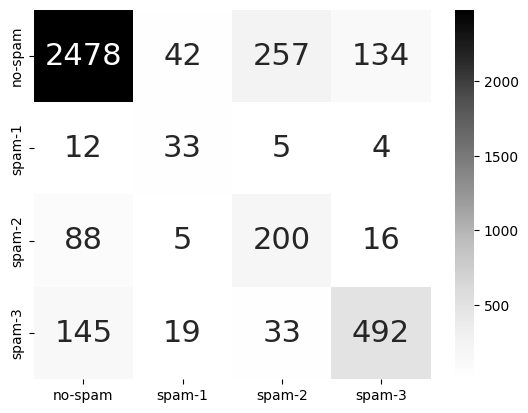

In [71]:
import os
import torch

model_name = "BiLSTM_BasisCustLinear_SBert4News"
model_path = f"../input/vispamreviews-models/{model_name}/{model_name}_(2).pth"
model = ViSpam_Classifier(model_name, task=2).to(device)
model.load_state_dict(torch.load(model_path))
true_labels, predicts = test(model, test_dataloader, task=2)
test_cm = evaluate(true_labels, predicts)
plotting_confusion_matrix(test_cm, model_name, task=2)

In [72]:
import pandas as pd

predict_df = pd.DataFrame({'comment': vispam_datasets['test']['comment'],
                           'category': vispam_datasets['test']['category'],
                           'description': vispam_datasets['test']['description'],
                           'spam_label': true_labels, 'predict': predicts})
predict_df.to_csv(os.path.join(model_name, f'{model_name}_test_prediction_(2).csv'), index=False)
wrong_df = predict_df[predict_df.spam_label != predict_df.predict]
sorted_df = wrong_df.sort_values(['spam_label', 'predict'], ascending=[False, False])
sorted_df

comment            category  \
59    H√†ng ·∫° g·ªüi b√†i v√†o v√†o ƒë√¢y ·∫° g·ª≠i g·ª≠i v√†o t√∫i n...          Th·ªùi Trang   
347   ƒê·ªìng h·ªì siuu ƒë·∫πp h·ª£p v·ªõi gi√° ti·ªÅn, ƒë√≥ng g√≥i h√†...          Th·ªùi Trang   
536   Giao h√†ng h∆°i l√¢u, ƒë√≥ng g√≥i ƒë∆∞·ª£c, n√≥i chung c≈©...  Nh√† C·ª≠a - ƒê·ªùi S·ªëng   
586   shop giao h√†ng nhanh, chu ƒë√°o, c·∫©n th·∫≠n r·∫•t h√†...             ƒê·ªì Ch∆°i   
628   Giao h√†ng nhanh ch√≥ng,bbdbfbfjfjhfbfhfhhfjfhfh...  Nh√† C·ª≠a - ƒê·ªùi S·ªëng   
...                                                 ...                 ...   
3199  H√†ng r·∫ª m√† ch·∫•t l∆∞·ª£ng nha mn n√™n mua ·∫° hihi mu...             M√°y ·∫¢nh   
3615  KhƒÉn ƒë·∫πp. üòâ N·∫øu hay mua h√†ng online gi·ªëng m√¨nh...  Nh√† C·ª≠a - ƒê·ªùi S·ªëng   
3734   L·∫ßn th·ª© 2 mua l·∫°i s·∫£n ph·∫©m n√†y.\r\nTh√∫ th·∫≠t m...             S·∫Øc ƒê·∫πp   
3799  Ch∆∞a bh mua ·ªü ƒë√¢u ƒë∆∞·ª£c v√°y gi√° n√†y v√† ch·∫•t l∆∞·ª£...          Th·ªùi Trang   
3879  Ch·∫•t l∆∞·ª£ng s·∫£n ph·∫©m tuy·ªát v·ªùi, giao h√†ng nhanh...                S√°ch   

                                            description  spam_label  predict  
59    Th·ªùi gian giao h√†ng d·ª± ki·∫øn cho s·∫£n ph·∫©m n√†y l...           3        2  
347   M√¥ t·∫£ s·∫£n ph·∫©m: Pin c√∫c √°o ƒë∆∞·ª£c s·ª≠ d·ª•ng ph·ªï bi...           3        2  
536   S·∫£n ph·∫©m khƒÉn gi·∫•y ∆∞·ªõt ƒë∆∞·ª£c s·∫£n xu·∫•t t·ª´ nguy√™n...           3        2  
586   M√°y T·∫°o Ti·∫øng ·ªín Tr·∫Øng Gi√∫p b√© ng·ªß ngon, s√¢u g...           3        2  
628   Cam k·∫øt: - H√†ng chu·∫©n c√¥ng ty, d√†y ƒë·∫πp - Kh√¥ng...           3        2  
...                                                 ...         ...      ...  
3199  ‚ö†Cam k·∫øt h√†ng ch·∫•t l∆∞·ª£ng ,ho√†n ti·ªÅn khi kh√°ch ...           0        1  
3615  GOOO STORE CAM K·∫æT ƒê·ªïi tr·∫£ v√† ho√†n ti·ªÅn 100% n...           0        1  
3734  Tinh chaÃÇÃÅt choÃÇÃÅng naÃÜÃÅng hieÃ£ÃÇu chiÃânh saÃÜÃÅc...           0        1  
3799  SUTANO K√≠nh ch√†o qu√Ω kh√°ch - Ch√∫c qu√Ω kh√°ch mu...           0        1  
3879   Th·ªùi gian giao h√†ng d·ª± ki·∫øn cho s·∫£n ph·∫©m n√†y ...           0        1  

[760 rows x 5 columns]

In [73]:
import torch
from transformers import AutoTokenizer
from sentence_transformers import SentenceTransformer

class_names = ['no-spam', 'spam']
spam_class_names = ['no-spam', 'spam-1', 'spam-2', 'spam-3']

def encode_text(text, word2idx, max_len=100):
    tokenized_text = word_tokenize(text)
    if len(tokenized_text) > max_len:
        tokenized_text = tokenized_text[:max_len]
    tokenized_text += ['<pad>'] * (max_len - len(tokenized_text))
    input_id = [word2idx.get(token, word2idx['<unk>']) for token in tokenized_text]
    return np.array(input_id)


def inference(model, comment, description, category, word2idx, task=1):
    if category not in category2idx:
        return
    
    model.eval()
    
    # Comment
    input_ids = encode_text(comment, word2idx, max_len=100)
    input_ids = torch.tensor(input_ids).unsqueeze(0).to(device)    
    
    # Description
    model_dir = "../input/vispamreviews-models/BiLSTM_BasisCustLinear_SBert4News/SBert4News/"
    model_name = "NlpHUST-vibert4news-base-cased"
    sentence_model = SentenceTransformer(model_dir + f'training_nli_{model_name}-task-{task}', device=device)
    encoded_description = sentence_model.encode(description, show_progress_bar=False)
    encoded_description = torch.tensor(encoded_description).unsqueeze(0).to(device)
    
    # Category
    category_id = torch.tensor(category2idx[category]).unsqueeze(0).to(device)
    
    with torch.no_grad():
        outputs = model(input_ids, category_id, encoded_description)
    predict_label = torch.argmax(outputs, dim=1)[0]
    probability = F.softmax(outputs, dim=1)[0][predict_label]
    
    print(f'Comment: {comment}')
    print(f'Description: {description}')
    print(f'Category: {category}')
    print(f'Predict: {class_names[predict_label] if task == 1 else spam_class_names[predict_label]}')
    print(f'Probability: {round(probability.cpu().item(), 4)}')

In [74]:
category2idx = {
    'Th·ªùi Trang': 0,
    'S√°ch': 1,
    'ƒêi·ªán Thoai - M√°y T√≠nh': 2,
    'ƒê·ªì Ch∆°i': 3,
    'S·∫Øc ƒê·∫πp': 4,
    'Th·ªÉ Thao': 5,
    'Nh√† C·ª≠a - ƒê·ªùi S·ªëng': 6,
    'Kh√°c': 7,
    'Ph∆∞∆°ng Ti·ªán': 8, 
    'M√°y ·∫¢nh': 9,
    'Gi√†y D√©p': 10,
    'ƒêi·ªán T·ª≠': 11,
}

task = 2
model_name = "BiLSTM_BasisCustLinear_SBert4News"
model = ViSpam_Classifier(model_name, task).to(device)
model_path = f"../input/vispamreviews-models/{model_name}/{model_name}_({task}).pth"
model.load_state_dict(torch.load(model_path))

comment = 'ƒëi·ªán tho·∫°i n√†y d√πng t·ªët, m·ªçi ng∆∞·ªùi n√™n mua nha'
description = "ƒëi·ªán tho·∫°i n√†y ph√π h·ª£p v·ªõi m·ªçi ng∆∞·ªùi, s·ª° h·ªØu k√≠ch th∆∞·ªõc m√†n h√¨nh l·ªõn, dung l∆∞·ª£ng cao"
category = 'ƒêi·ªán Thoai - M√°y T√≠nh'
inference(model, comment, description, category, word2idx, task)

Loaded pretrained embeddings, weights are not trainable.
Comment: ƒëi·ªán tho·∫°i n√†y d√πng t·ªët, m·ªçi ng∆∞·ªùi n√™n mua nha
Description: ƒëi·ªán tho·∫°i n√†y ph√π h·ª£p v·ªõi m·ªçi ng∆∞·ªùi, s·ª° h·ªØu k√≠ch th∆∞·ªõc m√†n h√¨nh l·ªõn, dung l∆∞·ª£ng cao
Category: ƒêi·ªán Thoai - M√°y T√≠nh
Predict: no-spam
Probability: 0.732
